In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, average_precision_score, precision_score, recall_score, f1_score, roc_auc_score,log_loss, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.base import clone
from sklearn.inspection import permutation_importance

In [3]:
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,BaggingClassifier, AdaBoostClassifier,HistGradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import (LogisticRegression, SGDClassifier,RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier, Perceptron)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

In [4]:
def proba(model, X):
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        return p[:,1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return model.predict(X)



In [5]:
def build_models():
    models = []
    models += [
        ("RandomForestClassifier",RandomForestClassifier(random_state=42, n_jobs=2, class_weight='balanced')),
        ("ExtraTreesClassifier",ExtraTreesClassifier(random_state=42, n_jobs=2, class_weight='balanced')),
        ("BaggingClassifier",BaggingClassifier(random_state=42, n_jobs=2)),
        ("AdaBoostClassifier",AdaBoostClassifier(random_state=42)),
        ("DecisionTreeClassifier",DecisionTreeClassifier(random_state=4, class_weight='balanced')),
        ("ExtraTreeClassifier",ExtraTreeClassifier(random_state=42, class_weight='balanced')),("HistGradientBoostingClassifier",HistGradientBoostingClassifier(random_state=42, class_weight='balanced'))]
    models.append(("XGBClassifier",XGBClassifier(random_state=42, n_jobs=2)))
    models.append(("LGBMClassifier",LGBMClassifier(random_state=42, n_jobs=2, class_weight='balanced')))
    models += [("LogisticRegression",LogisticRegression(max_iter=1000,random_state=42, n_jobs=2, class_weight='balanced')),("LinearSVC",LinearSVC(random_state=42, class_weight='balanced')),
        ("CalibratedClassifierCV",CalibratedClassifierCV(estimator=LinearSVC(random_state=42),method="sigmoid", cv=3)),
        ("SGDClassifier",SGDClassifier(early_stopping=True,random_state=42, class_weight='balanced')),
        ("RidgeClassifier",RidgeClassifier(random_state=42, class_weight='balanced')),
        ("Perceptron",Perceptron(random_state=42, class_weight='balanced')),
        ("PassiveAggressiveClassifier",PassiveAggressiveClassifier(random_state=42, class_weight='balanced')),
        ("LinearDiscriminantAnalysis",LinearDiscriminantAnalysis()), ("RidgeClassifierCV",RidgeClassifierCV(class_weight='balanced')),
        ("QuadraticDiscriminantAnalysis",QuadraticDiscriminantAnalysis(reg_param=1e-3))]

    models += [("GaussianNB", GaussianNB()),("BernoulliNB", BernoulliNB())]
    models += [("DummyClassifier",DummyClassifier(strategy="most_frequent", random_state=42))]

    return models

In [6]:
down_df = pd.read_pickle("down_df.pkl")

In [7]:
down_df.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'FAU', 'FCU', 'FGU',
       'FTU', 'RAU', 'RCU', 'RGU', 'RTU', 'DP', 'AF', 'GT', 'GQ', 'AD', 'NAD',
       'AU', 'CU', 'GU', 'TU', 'NDP', 'NAF', 'NAU', 'NCU', 'NGU', 'NTU',
       'SEQ_CONTEXT', 'key', 'label', 'ref_ad', 'alt_ad', 'ALT_SEQ_CONTEXT',
       'GC', 'STRAND_BIAS', 'HOMO', 'DELTA_AF', 'DP_normal', 'NDP_normal',
       'NAF_normal', 'HOMO_normal', 'STRAND_BIAS_normal', 'QUAL_normal',
       'DELTA_AF_normal', 'REF_A', 'REF_C', 'REF_G', 'REF_T', 'ALT_A', 'ALT_C',
       'ALT_G', 'ALT_T'],
      dtype='object')

In [8]:
down_df = down_df.drop(['CHROM', 'POS', 'REF', 'AF','NAF_normal','NAF','ALT', 'QUAL', 'FILTER', 'FAU', 'FCU', 'FGU',
       'FTU', 'RAU', 'RCU', 'RGU', 'RTU', 'DP',  'GT', 'GQ', 'AD', 'NAD',
       'AU', 'CU', 'GU', 'TU', 'NDP', 'NAU', 'NCU', 'NGU', 'NTU',
       'SEQ_CONTEXT', 'key','ref_ad', 'alt_ad', 'ALT_SEQ_CONTEXT','STRAND_BIAS', 'HOMO', "DELTA_AF" ], axis =1)

In [9]:
down_df.columns

Index(['label', 'GC', 'DP_normal', 'NDP_normal', 'HOMO_normal',
       'STRAND_BIAS_normal', 'QUAL_normal', 'DELTA_AF_normal', 'REF_A',
       'REF_C', 'REF_G', 'REF_T', 'ALT_A', 'ALT_C', 'ALT_G', 'ALT_T'],
      dtype='object')

In [10]:
down_df = down_df.rename(columns={"STRAND_BIAS_normal":"STRAND_BIAS","NAF_normal": "NAF","AF_normal":"AF","HOMO_normal":"HOMO","NDP_normal":"NDP","DP_normal":"DP", "QUAL_normal":"QUAL","DELTA_AF_normal":"DELTA_AF"})

In [11]:
down_df.columns

Index(['label', 'GC', 'DP', 'NDP', 'HOMO', 'STRAND_BIAS', 'QUAL', 'DELTA_AF',
       'REF_A', 'REF_C', 'REF_G', 'REF_T', 'ALT_A', 'ALT_C', 'ALT_G', 'ALT_T'],
      dtype='object')

In [12]:
X_all = down_df.drop("label", axis=1).values
y_all = down_df["label"].values


In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_all, y_all, test_size=0.25, stratify=y_all, random_state=42)
print(f"Train-Val: {X_train_val.shape}, Test: {X_test.shape}")

Train-Val: (31157, 15), Test: (10386, 15)


In [14]:
c_v = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = build_models()

In [15]:
baseline_rows = []

for name, est in models:
    base_est = clone(est)
    scores = cross_val_score(base_est,X_train_val,y_train_val,cv=c_v,scoring="f1",n_jobs=2)
    baseline_rows.append({"model": name,"cv_mean": float(np.mean(scores)),"cv_std": float(np.std(scores))})

baseline_df = pd.DataFrame(baseline_rows).sort_values(["cv_mean"], ascending=False).reset_index(drop=True)


In [16]:
baseline_df

,model,cv_mean,cv_std
0,LGBMClassifier,0.886895,0.003789
1,HistGradientBoostingClassifier,0.886338,0.003124
2,RandomForestClassifier,0.885497,0.005409
3,ExtraTreesClassifier,0.883434,0.006062
4,XGBClassifier,0.883222,0.003282
5,LinearSVC,0.879217,0.003609
6,LogisticRegression,0.878792,0.003448
7,CalibratedClassifierCV,0.878626,0.003815
8,RidgeClassifierCV,0.878091,0.004255
9,RidgeClassifier,0.878057,0.004170


[LightGBM] [Info] Number of positive: 15656, number of negative: 15501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1404
[LightGBM] [Info] Number of data points in the train set: 31157, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\shwet\Desktop\Somatic_Var\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\shwet\Desktop\Somatic_Var\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


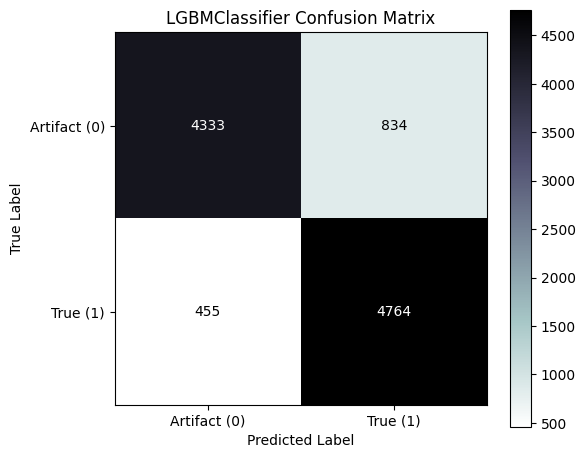

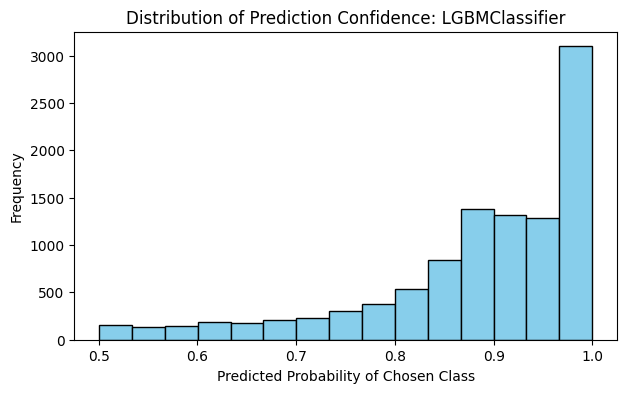

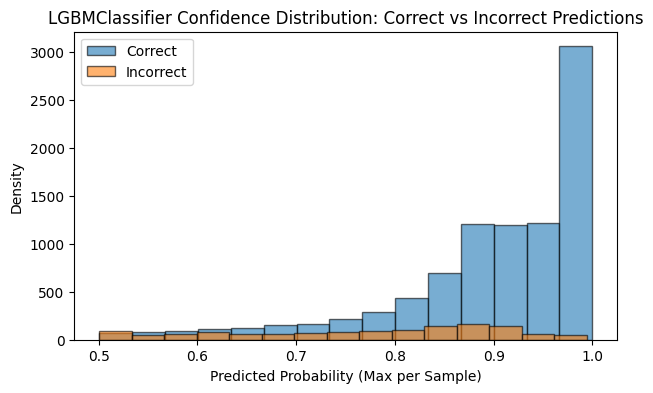

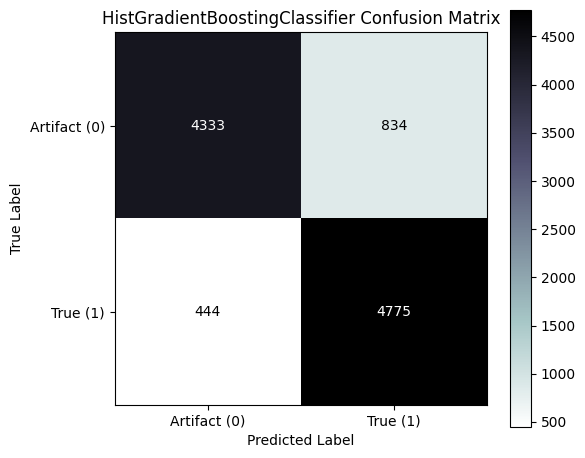

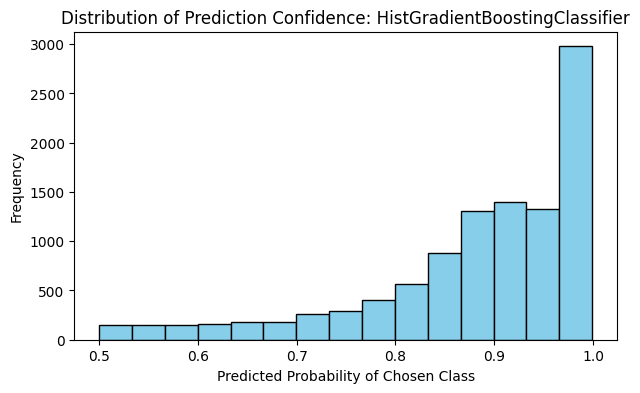

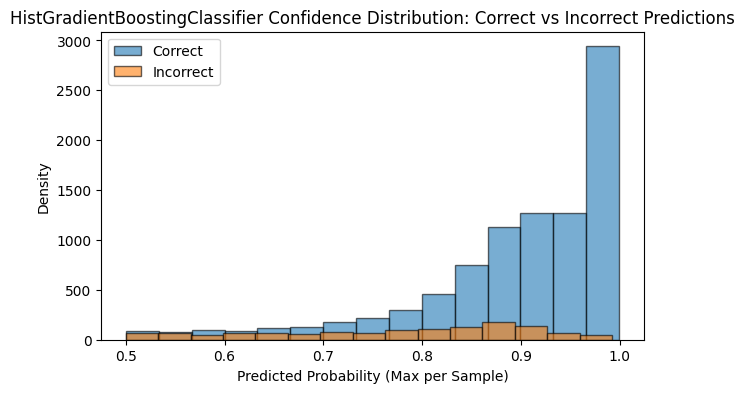

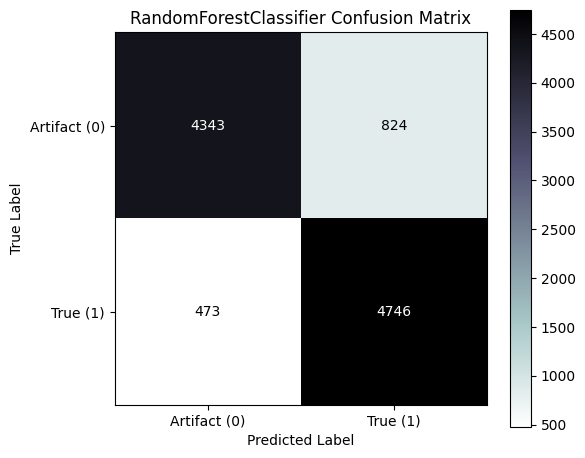

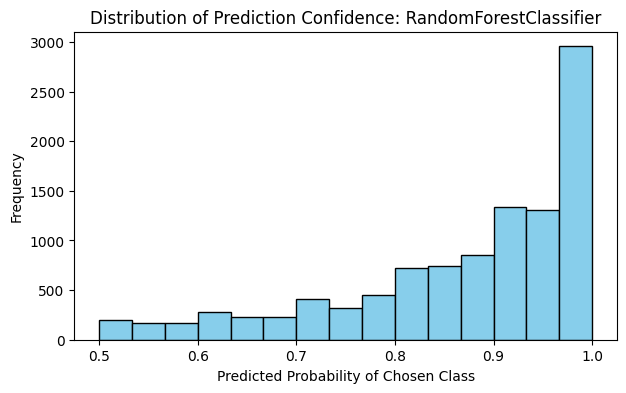

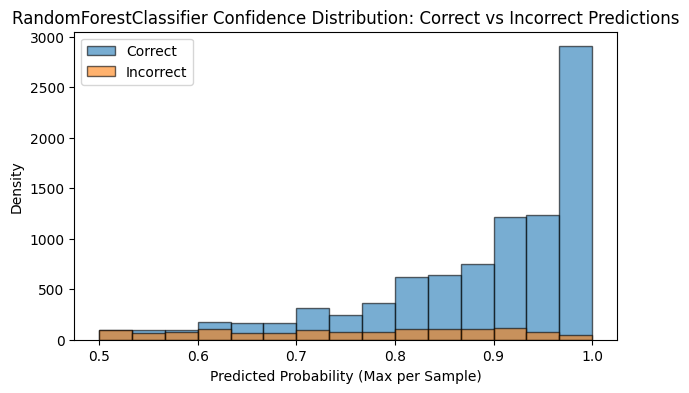

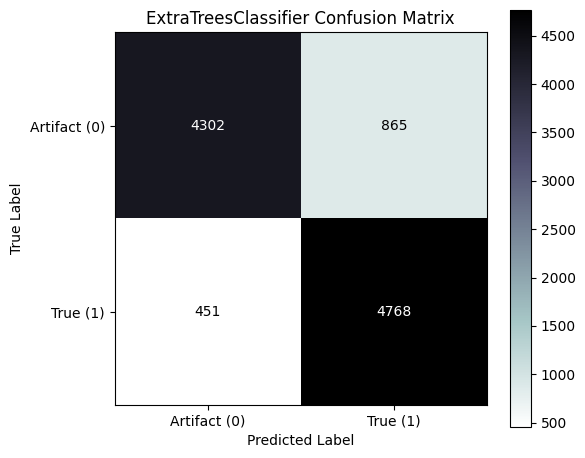

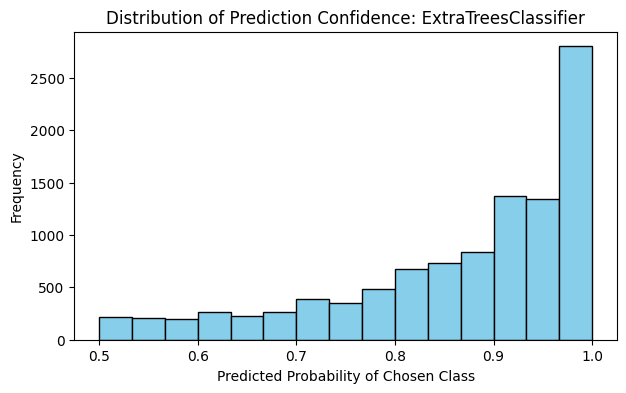

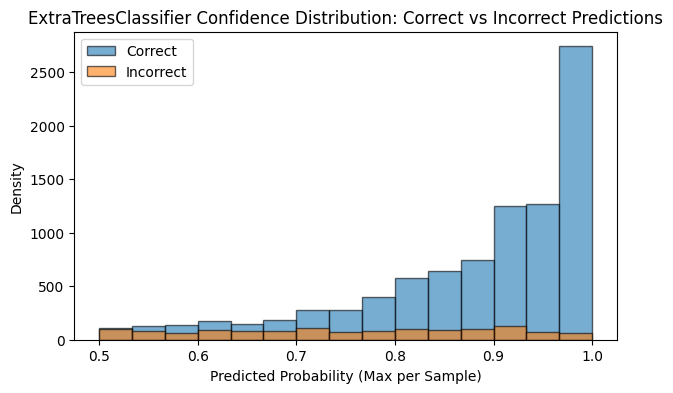

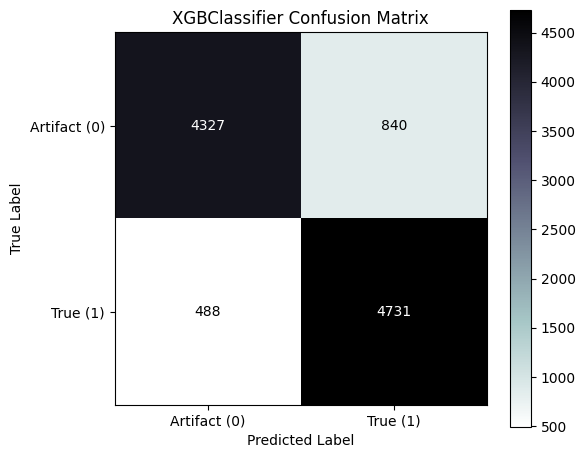

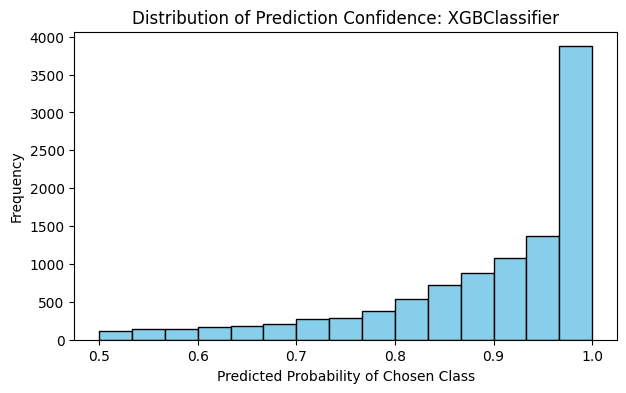

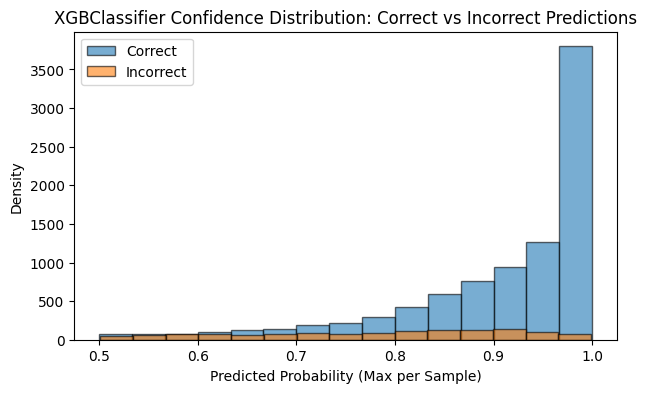

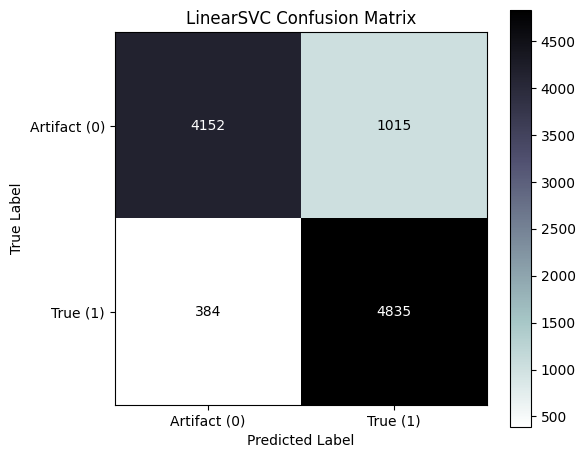

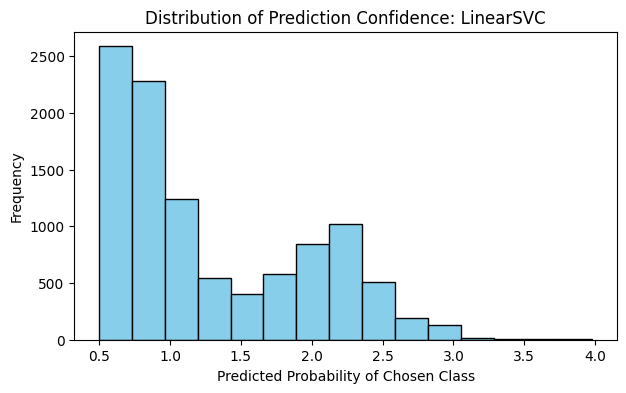

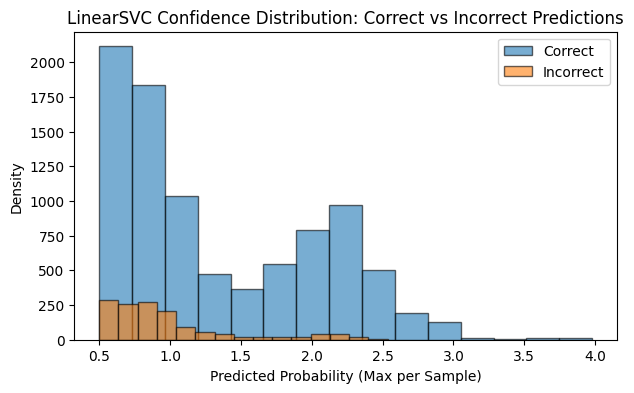

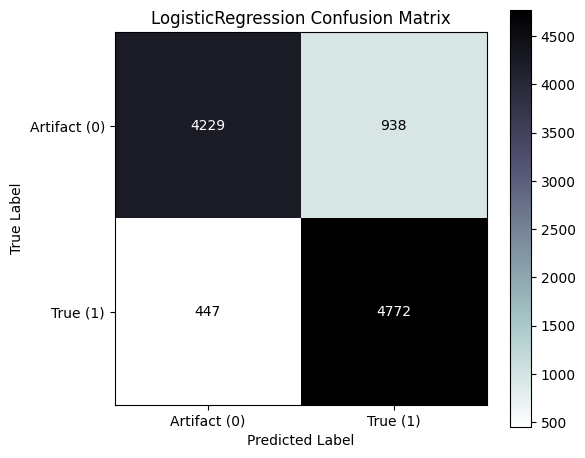

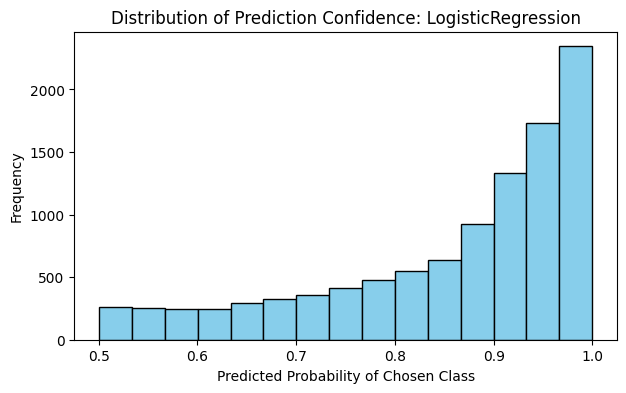

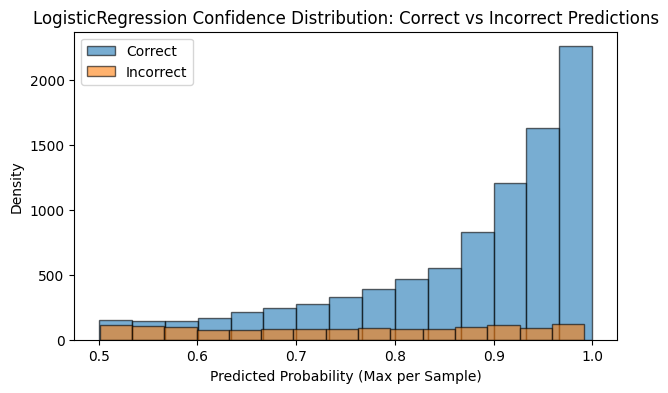

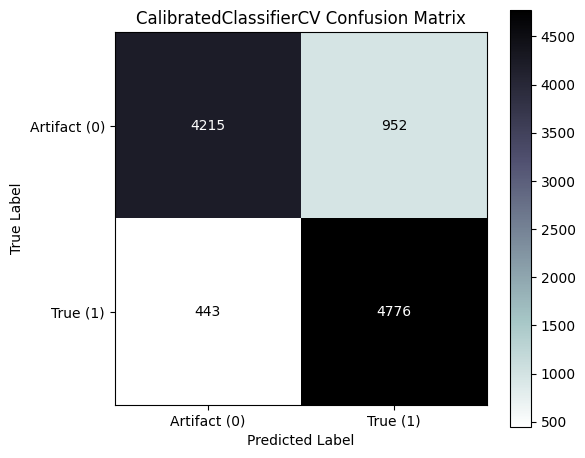

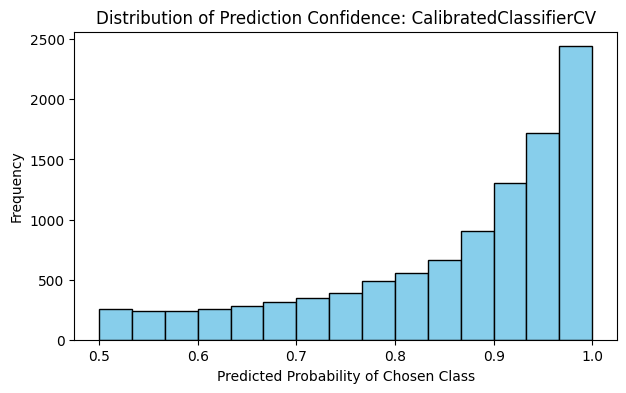

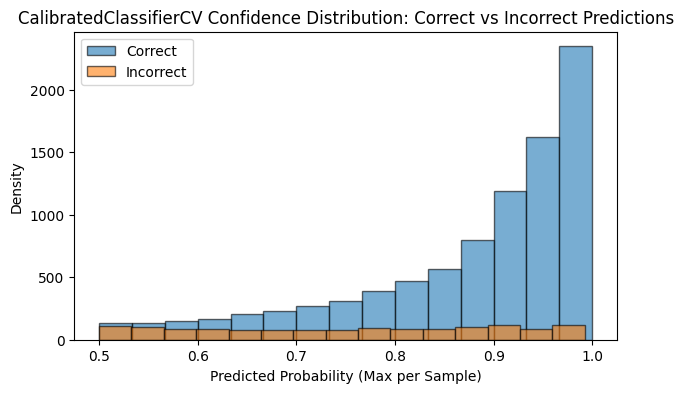

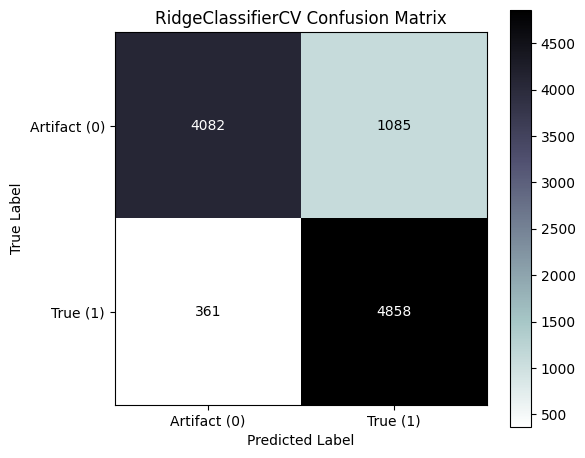

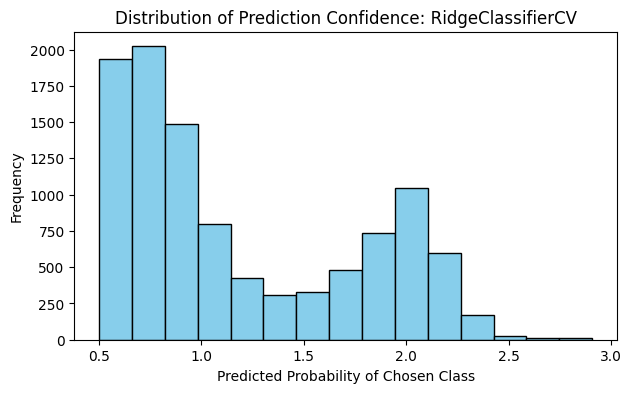

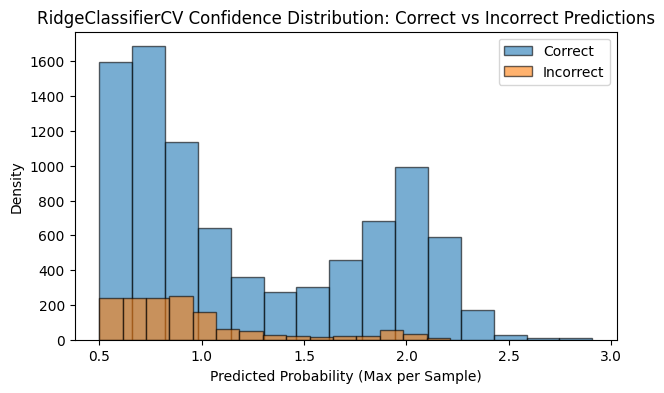

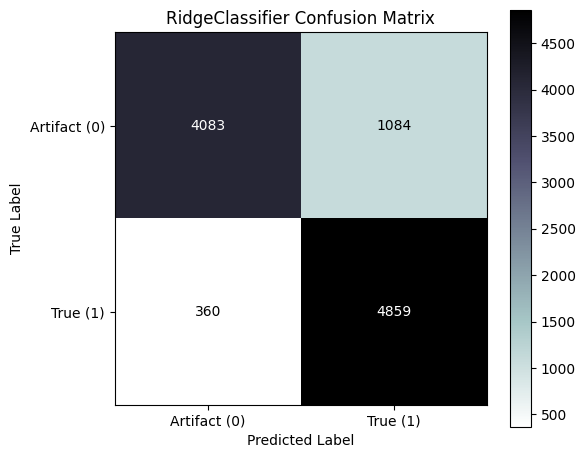

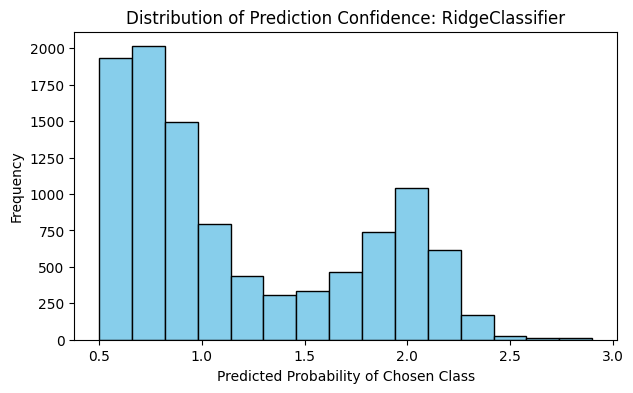

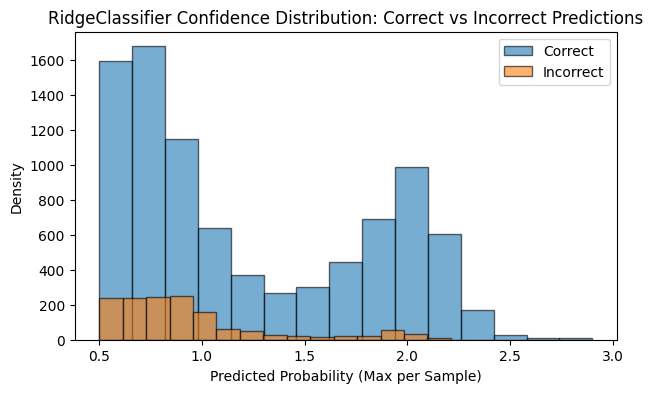

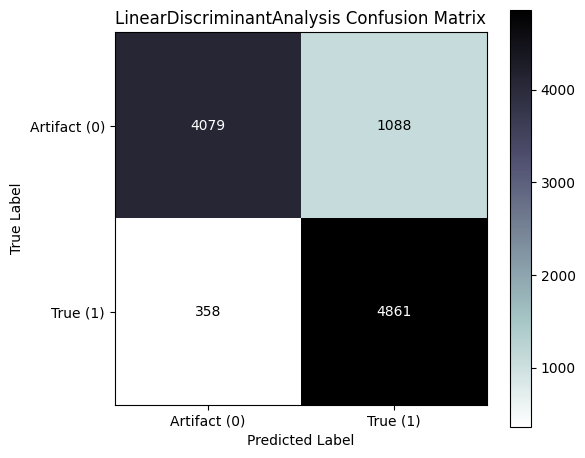

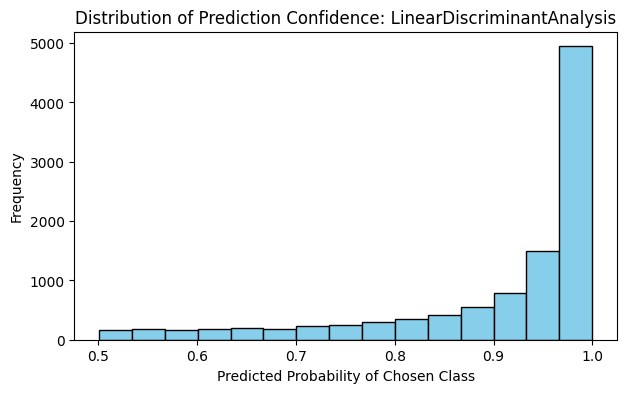

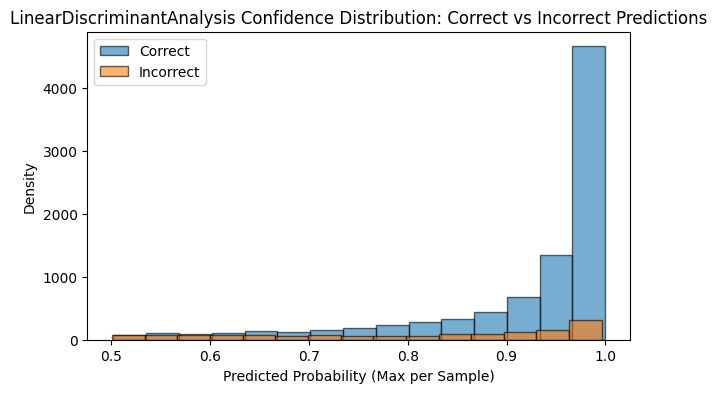

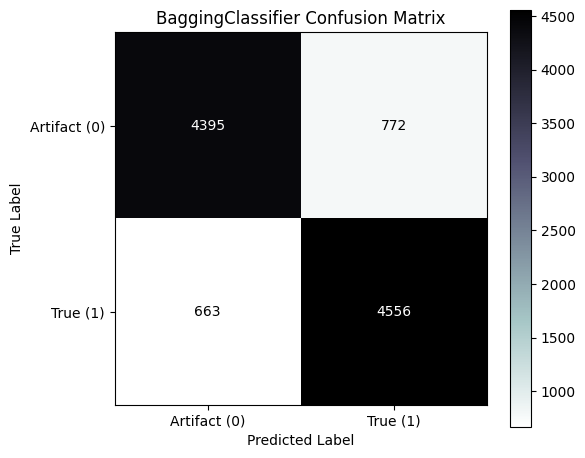

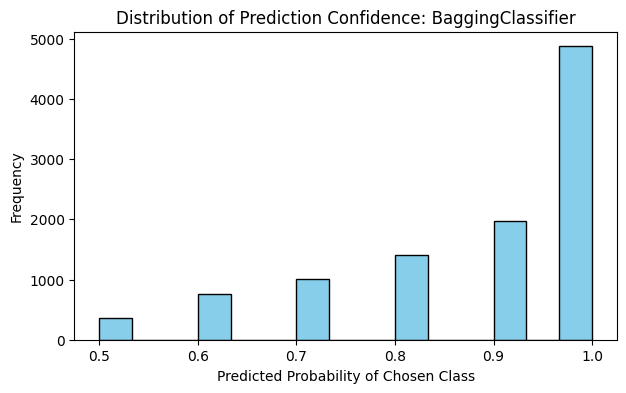

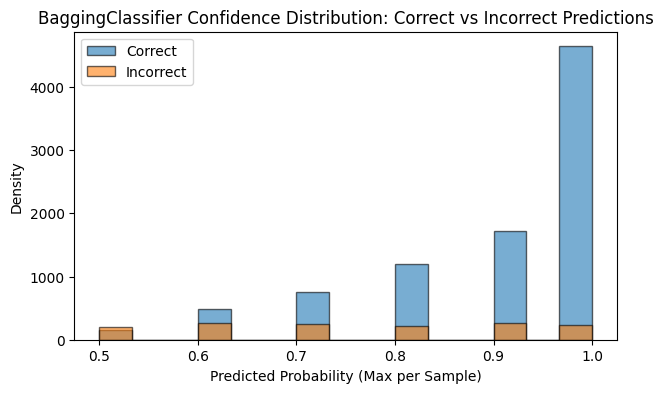

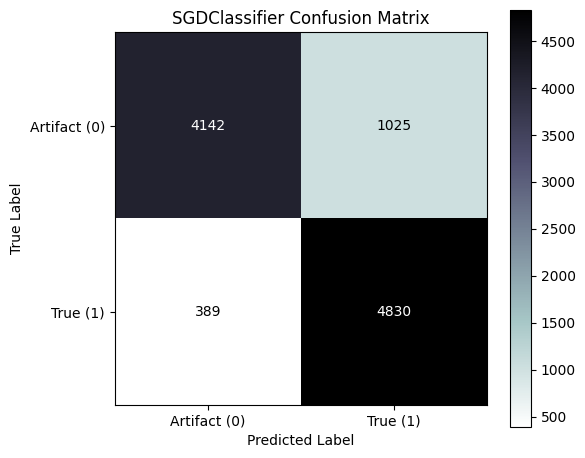

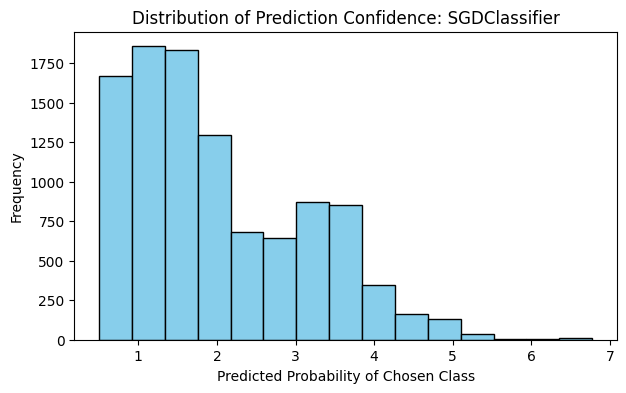

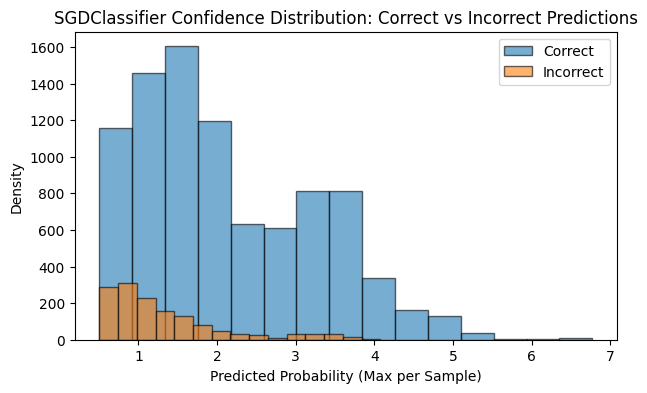

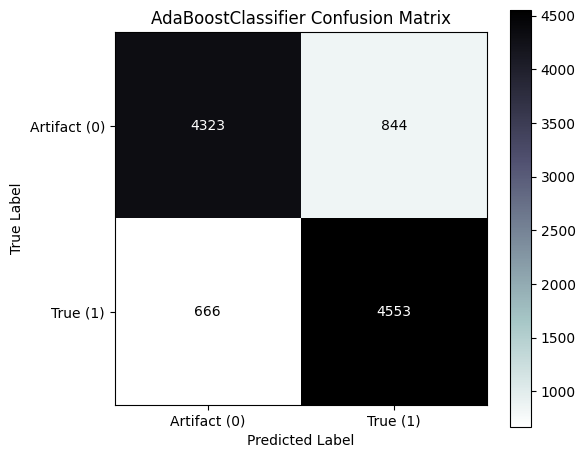

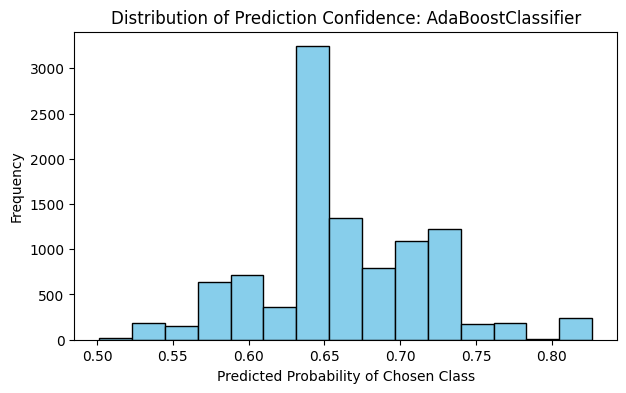

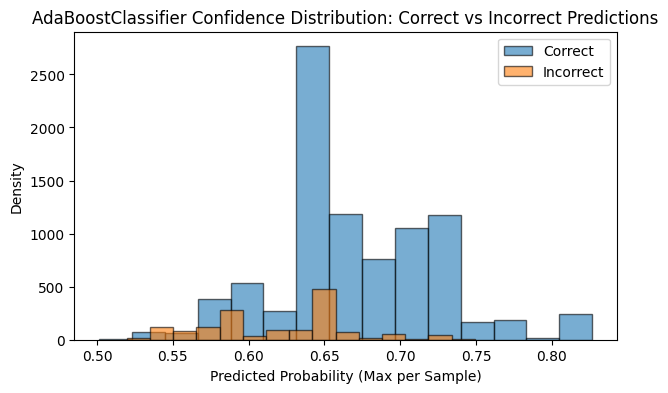

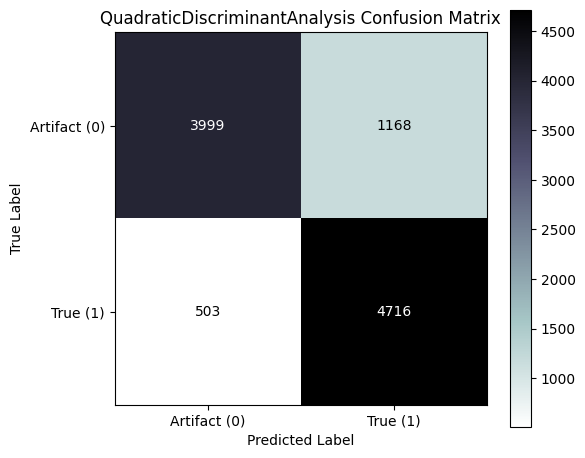

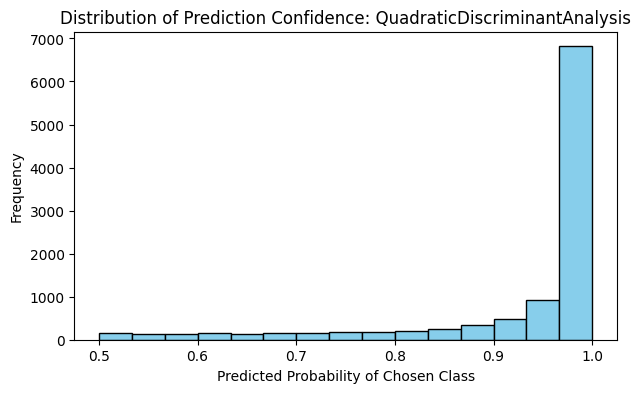

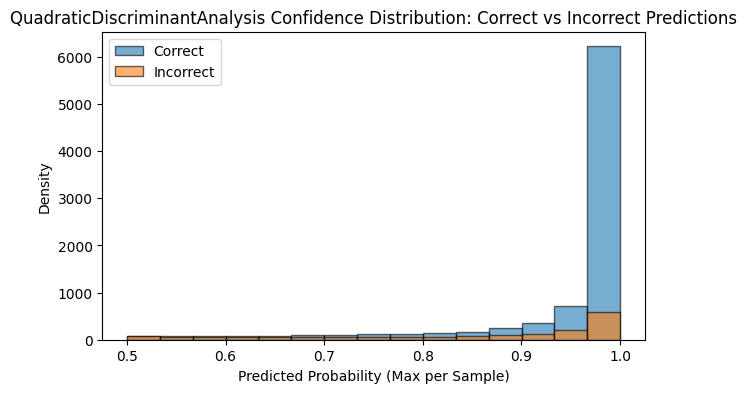

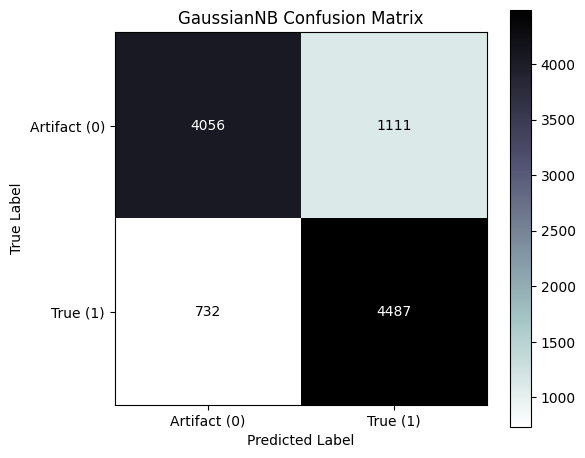

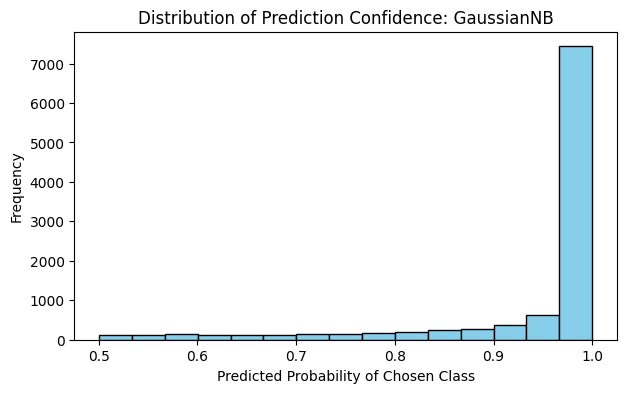

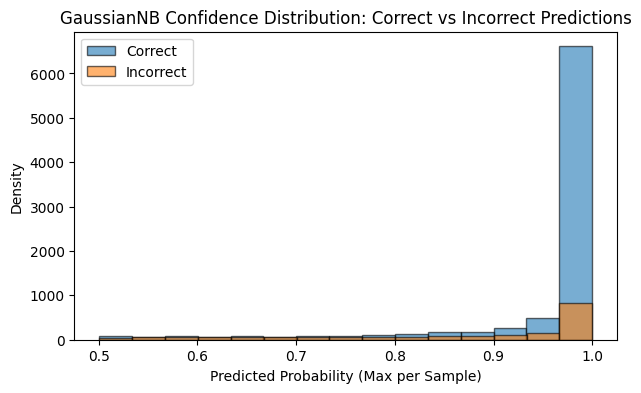

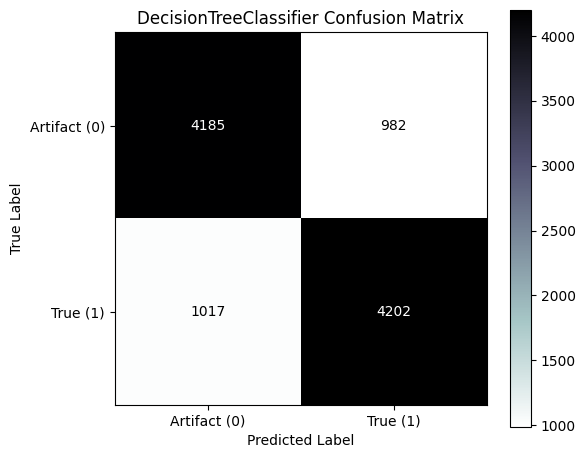

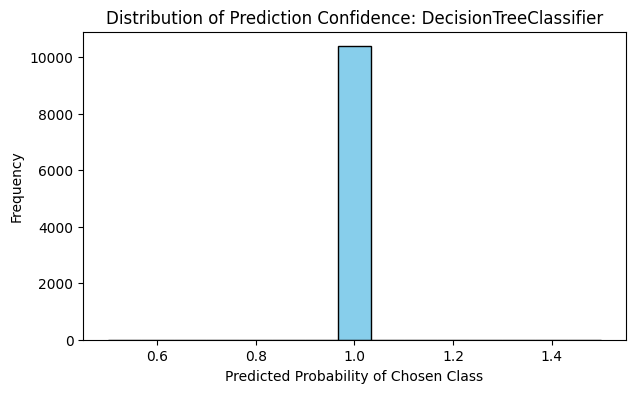

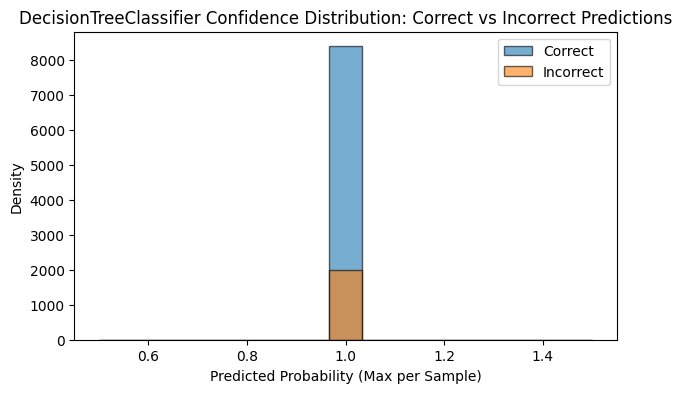

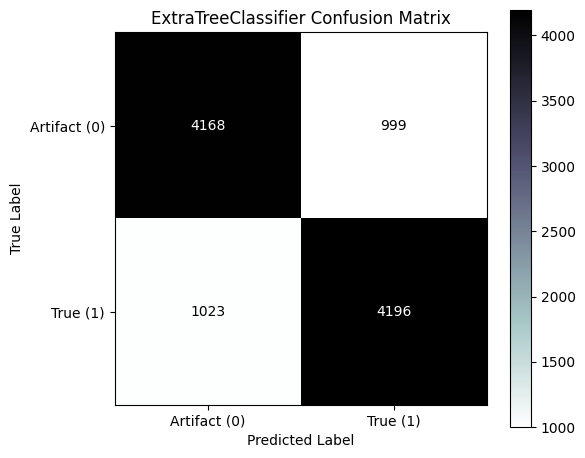

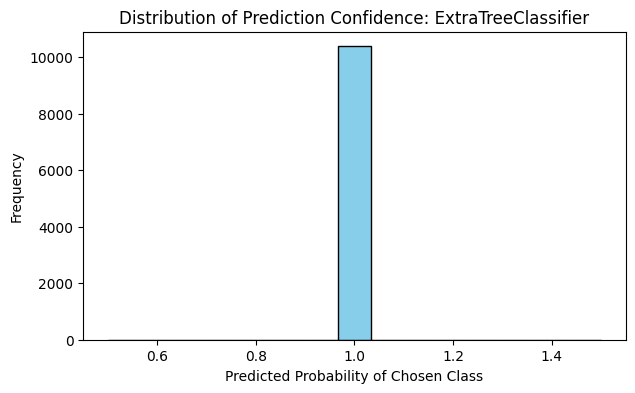

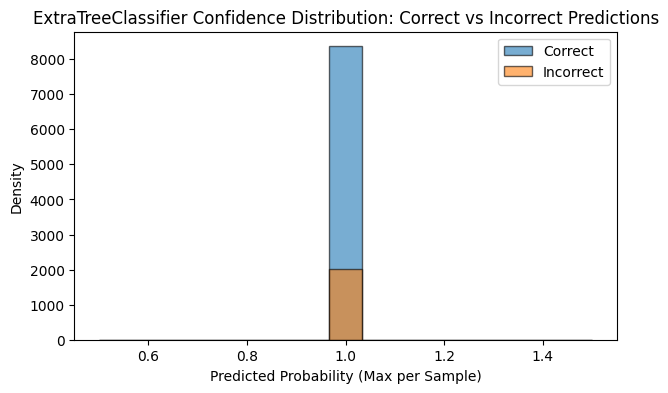

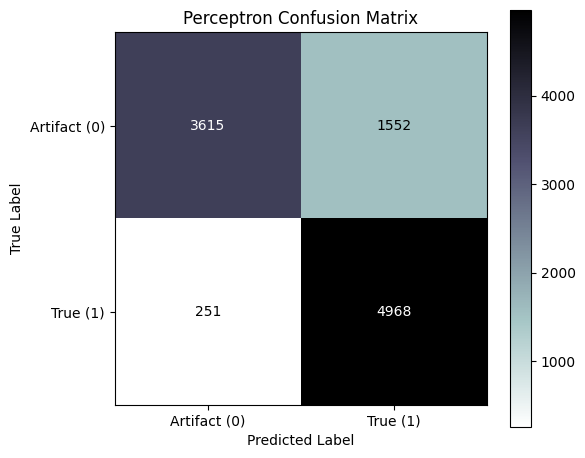

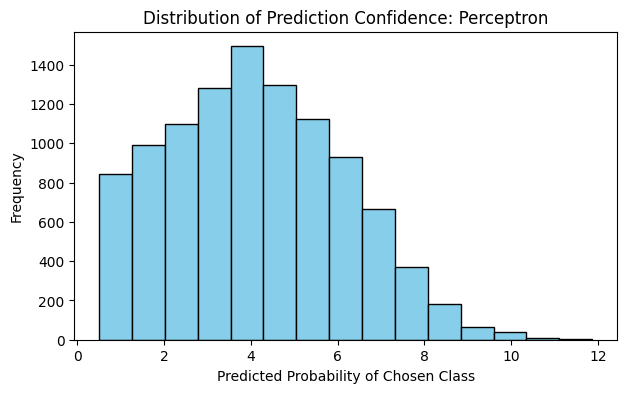

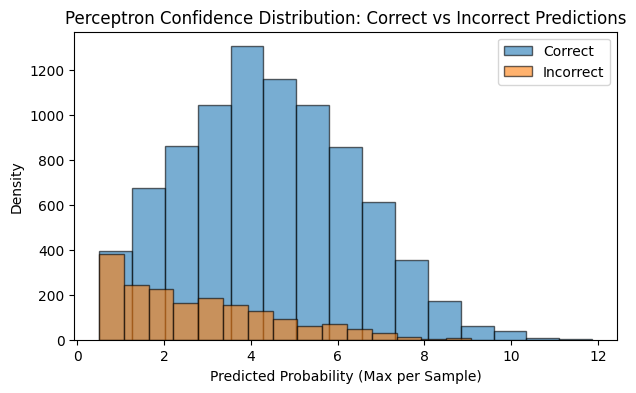

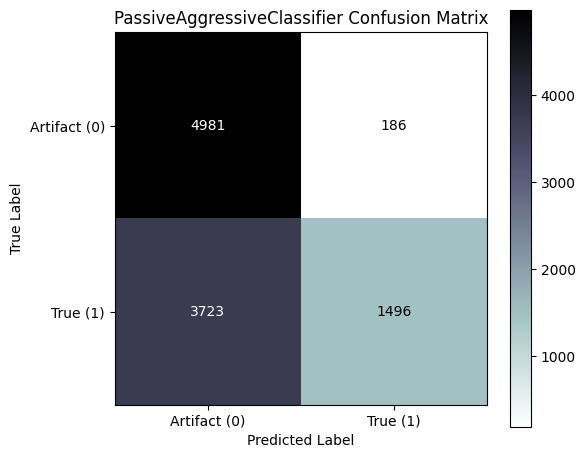

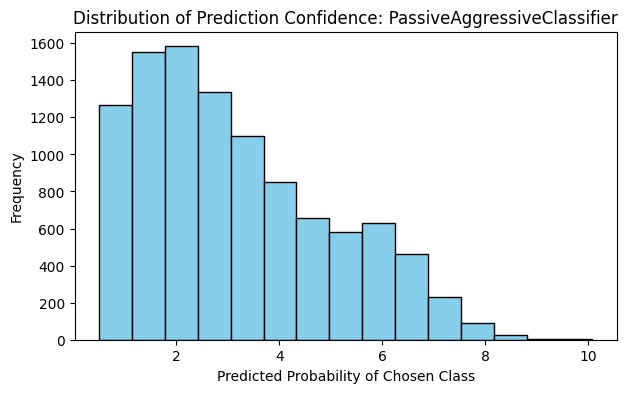

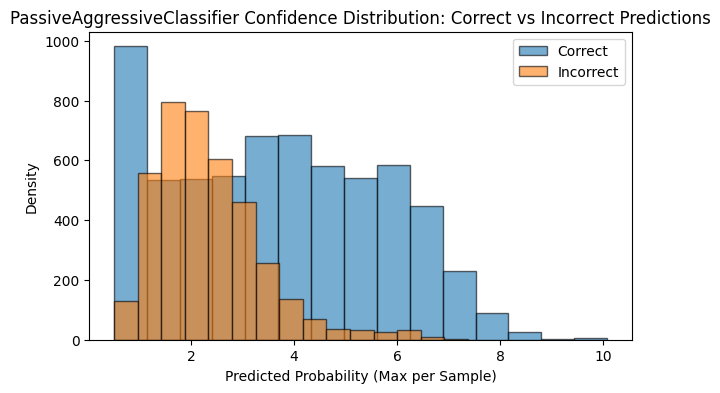

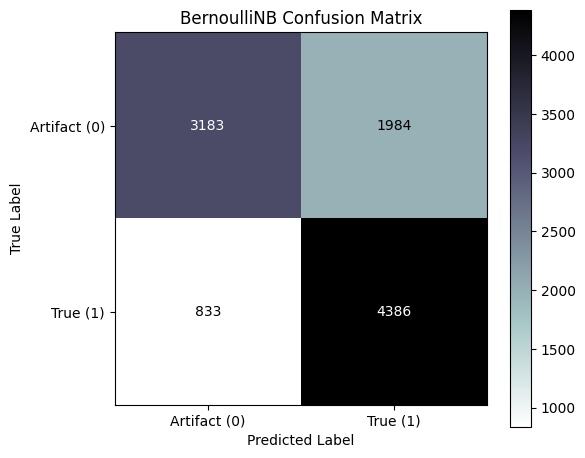

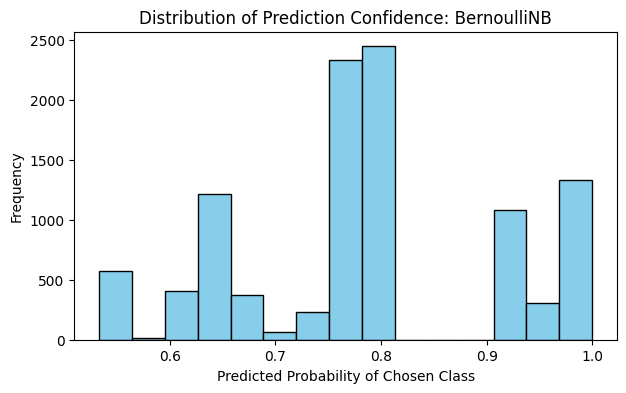

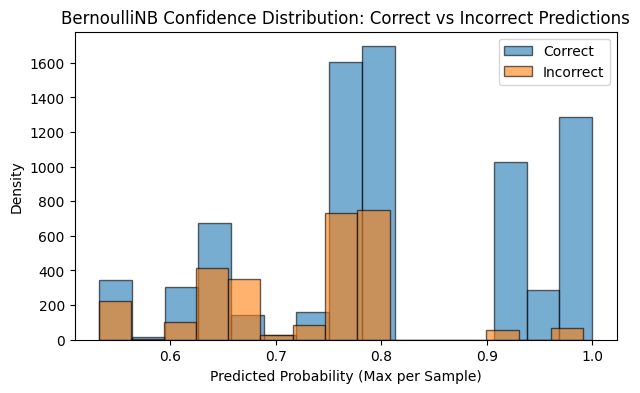

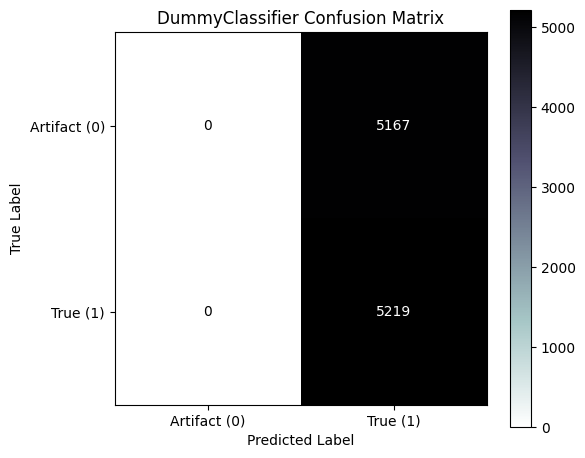

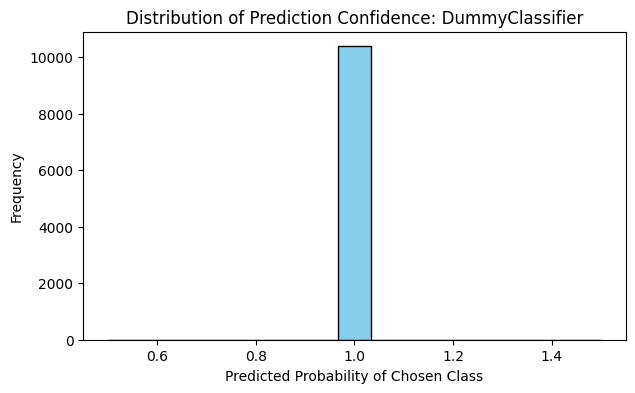

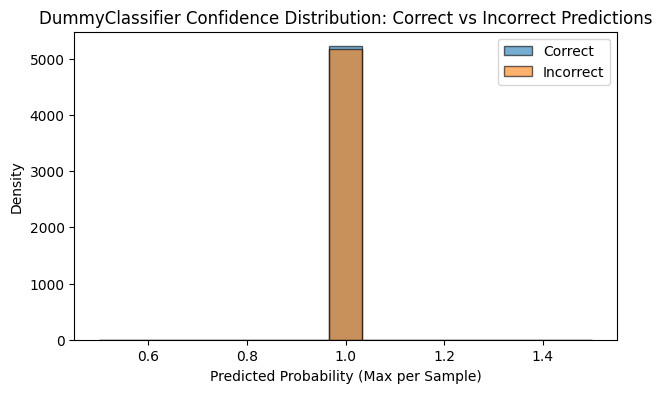

In [17]:
results = []
top_mod = {}  
name_to_est = {n: e for n, e in models}
for _, row in baseline_df.iterrows():
    name = row["model"]
    est = clone(name_to_est[name])

    # Fit on all training/validation data 
    est.fit(X_train_val, y_train_val)

    # Evaluate on TEST
    y_pred = est.predict(X_test)
    y_score = proba(est, X_test)

    acc  = accuracy_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    rocauc = roc_auc_score(y_test, y_score)
    auprc = average_precision_score(y_test, y_score)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="bone_r")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks([0, 1], ["Artifact (0)", "True (1)"])
    plt.yticks([0, 1], ["Artifact (0)", "True (1)"])
    plt.colorbar()
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.savefig(f"{name} Confusion Matrix")
    plt.show();
    
    if y_score.ndim == 1: 
      p = y_score
      conf = np.maximum(p, 1-p)   
    else: 
      conf = y_score.max(axis=1)

    plt.figure(figsize=(7,4))
    plt.hist(conf, bins=15, color='skyblue', edgecolor='k')
    plt.xlabel("Predicted Probability of Chosen Class")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Prediction Confidence: {name}")
    plt.savefig(f"Distribution of Prediction Confidence {name}")
    plt.show();

    correct_mask = (y_pred == y_test)
    plt.figure(figsize=(7,4))
    plt.hist(conf[correct_mask], bins=15, alpha=0.6, edgecolor='k', label="Correct")
    plt.hist(conf[~correct_mask], bins=15, alpha=0.6, edgecolor='k', label="Incorrect")
    plt.xlabel("Predicted Probability (Max per Sample)")
    plt.ylabel("Density")
    plt.title(f"{name} Confidence Distribution: Correct vs Incorrect Predictions")
    plt.legend()
    plt.savefig(f"{name} Confidence Distribution: Correct vs Incorrect Predictions")
    plt.show();

    top_mod[name] = est
    results.append({"model": name,"accuracy": acc,"F1 score": f1,"precision": prec,
        "recall": rec,"roc_auc": rocauc,"area_under_prec_recall": auprc,"confusion_matrix": cm})

test_df = pd.DataFrame(results).sort_values("accuracy", ascending=False).reset_index(drop=True)

In [18]:
sort_test_df = test_df.sort_values("accuracy", ascending=False).reset_index(drop=True)

In [19]:
sort_f1_test = test_df.sort_values("F1 score", ascending=False).reset_index(drop=True)

In [20]:
top7 = pd.DataFrame(sort_test_df.head(7))

In [ ]:
top5 = pd.DataFrame(sort_test_df.head())

In [21]:
top7

,model,accuracy,F1 score,precision,recall,roc_auc,area_under_prec_recall,confusion_matrix
0,HistGradientBoostingClassifier,0.876950,0.881973,0.851310,0.914926,0.936892,0.923237,"[[4333, 834], [444, 4775]]"
1,LGBMClassifier,0.875891,0.880836,0.851018,0.912819,0.936700,0.922971,"[[4333, 834], [455, 4764]]"
2,RandomForestClassifier,0.875120,0.879785,0.852065,0.909370,0.932910,0.915600,"[[4343, 824], [473, 4746]]"
3,ExtraTreesClassifier,0.873291,0.878732,0.846441,0.913585,0.929293,0.910259,"[[4302, 865], [451, 4768]]"
4,XGBClassifier,0.872136,0.876923,0.849219,0.906495,0.933853,0.918341,"[[4327, 840], [488, 4731]]"
5,LogisticRegression,0.866647,0.873273,0.835727,0.914351,0.919992,0.900795,"[[4229, 938], [447, 4772]]"
6,CalibratedClassifierCV,0.865685,0.872568,0.833799,0.915118,0.919994,0.901226,"[[4215, 952], [443, 4776]]"


In [22]:
test_df

,model,accuracy,F1 score,precision,recall,roc_auc,area_under_prec_recall,confusion_matrix
0,HistGradientBoostingClassifier,0.876950,0.881973,0.851310,0.914926,0.936892,0.923237,"[[4333, 834], [444, 4775]]"
1,LGBMClassifier,0.875891,0.880836,0.851018,0.912819,0.936700,0.922971,"[[4333, 834], [455, 4764]]"
2,RandomForestClassifier,0.875120,0.879785,0.852065,0.909370,0.932910,0.915600,"[[4343, 824], [473, 4746]]"
3,ExtraTreesClassifier,0.873291,0.878732,0.846441,0.913585,0.929293,0.910259,"[[4302, 865], [451, 4768]]"
4,XGBClassifier,0.872136,0.876923,0.849219,0.906495,0.933853,0.918341,"[[4327, 840], [488, 4731]]"
5,LogisticRegression,0.866647,0.873273,0.835727,0.914351,0.919992,0.900795,"[[4229, 938], [447, 4772]]"
6,CalibratedClassifierCV,0.865685,0.872568,0.833799,0.915118,0.919994,0.901226,"[[4215, 952], [443, 4776]]"
7,LinearSVC,0.865299,0.873611,0.826496,0.926423,0.919993,0.901232,"[[4152, 1015], [384, 4835]]"
8,SGDClassifier,0.863855,0.872314,0.824936,0.925465,0.917967,0.895901,"[[4142, 1025], [389, 4830]]"
9,BaggingClassifier,0.861833,0.863942,0.855105,0.872964,0.917108,0.882227,"[[4395, 772], [663, 4556]]"


In [23]:
bar_col = (0.17, # redness
         0.12, # greenness
         0.30, # blueness
         0.6 )# transparency (from https://python-graph-gallery.com/3-control-color-of-barplots/) 

In [24]:
f1_bar_col = (0.30, # redness
         0.12, # greenness
         0.17, # blueness
         0.6 )# transparency (from https://python-graph-gallery.com/3-control-color-of-barplots/)

In [25]:
only_dum = pd.DataFrame(sort_test_df.tail(1))

In [26]:
top7 = pd.concat([top7, only_dum], ignore_index=True)

In [27]:
top7

,model,accuracy,F1 score,precision,recall,roc_auc,area_under_prec_recall,confusion_matrix
0,HistGradientBoostingClassifier,0.876950,0.881973,0.851310,0.914926,0.936892,0.923237,"[[4333, 834], [444, 4775]]"
1,LGBMClassifier,0.875891,0.880836,0.851018,0.912819,0.936700,0.922971,"[[4333, 834], [455, 4764]]"
2,RandomForestClassifier,0.875120,0.879785,0.852065,0.909370,0.932910,0.915600,"[[4343, 824], [473, 4746]]"
3,ExtraTreesClassifier,0.873291,0.878732,0.846441,0.913585,0.929293,0.910259,"[[4302, 865], [451, 4768]]"
4,XGBClassifier,0.872136,0.876923,0.849219,0.906495,0.933853,0.918341,"[[4327, 840], [488, 4731]]"
5,LogisticRegression,0.866647,0.873273,0.835727,0.914351,0.919992,0.900795,"[[4229, 938], [447, 4772]]"
6,CalibratedClassifierCV,0.865685,0.872568,0.833799,0.915118,0.919994,0.901226,"[[4215, 952], [443, 4776]]"
7,DummyClassifier,0.502503,0.668888,0.502503,1.000000,0.500000,0.502503,"[[0, 5167], [0, 5219]]"


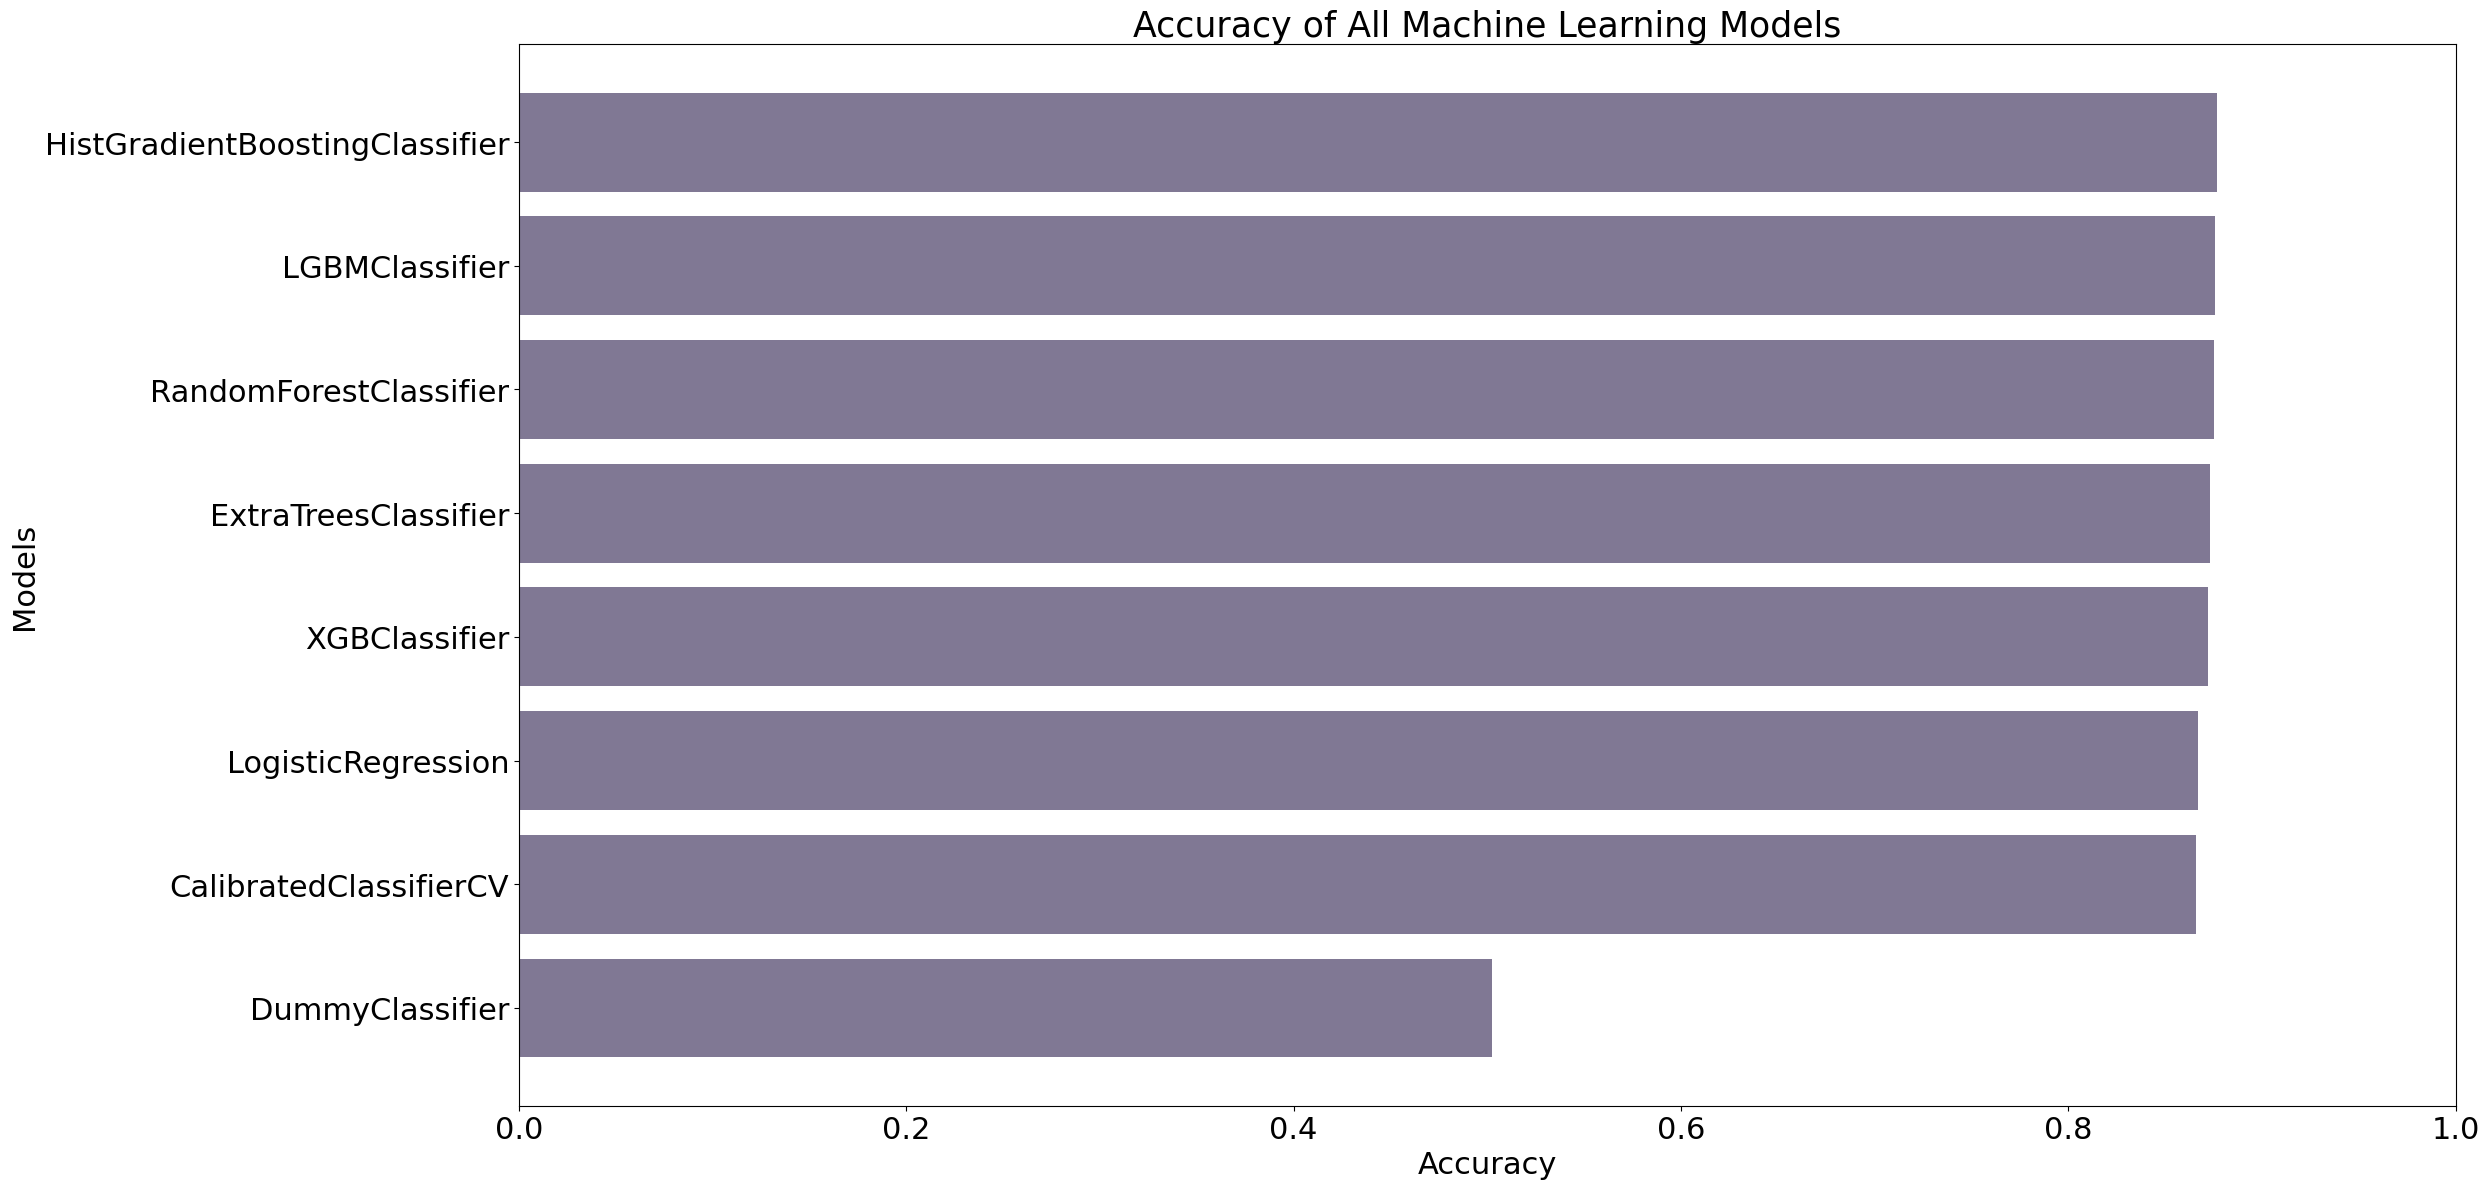

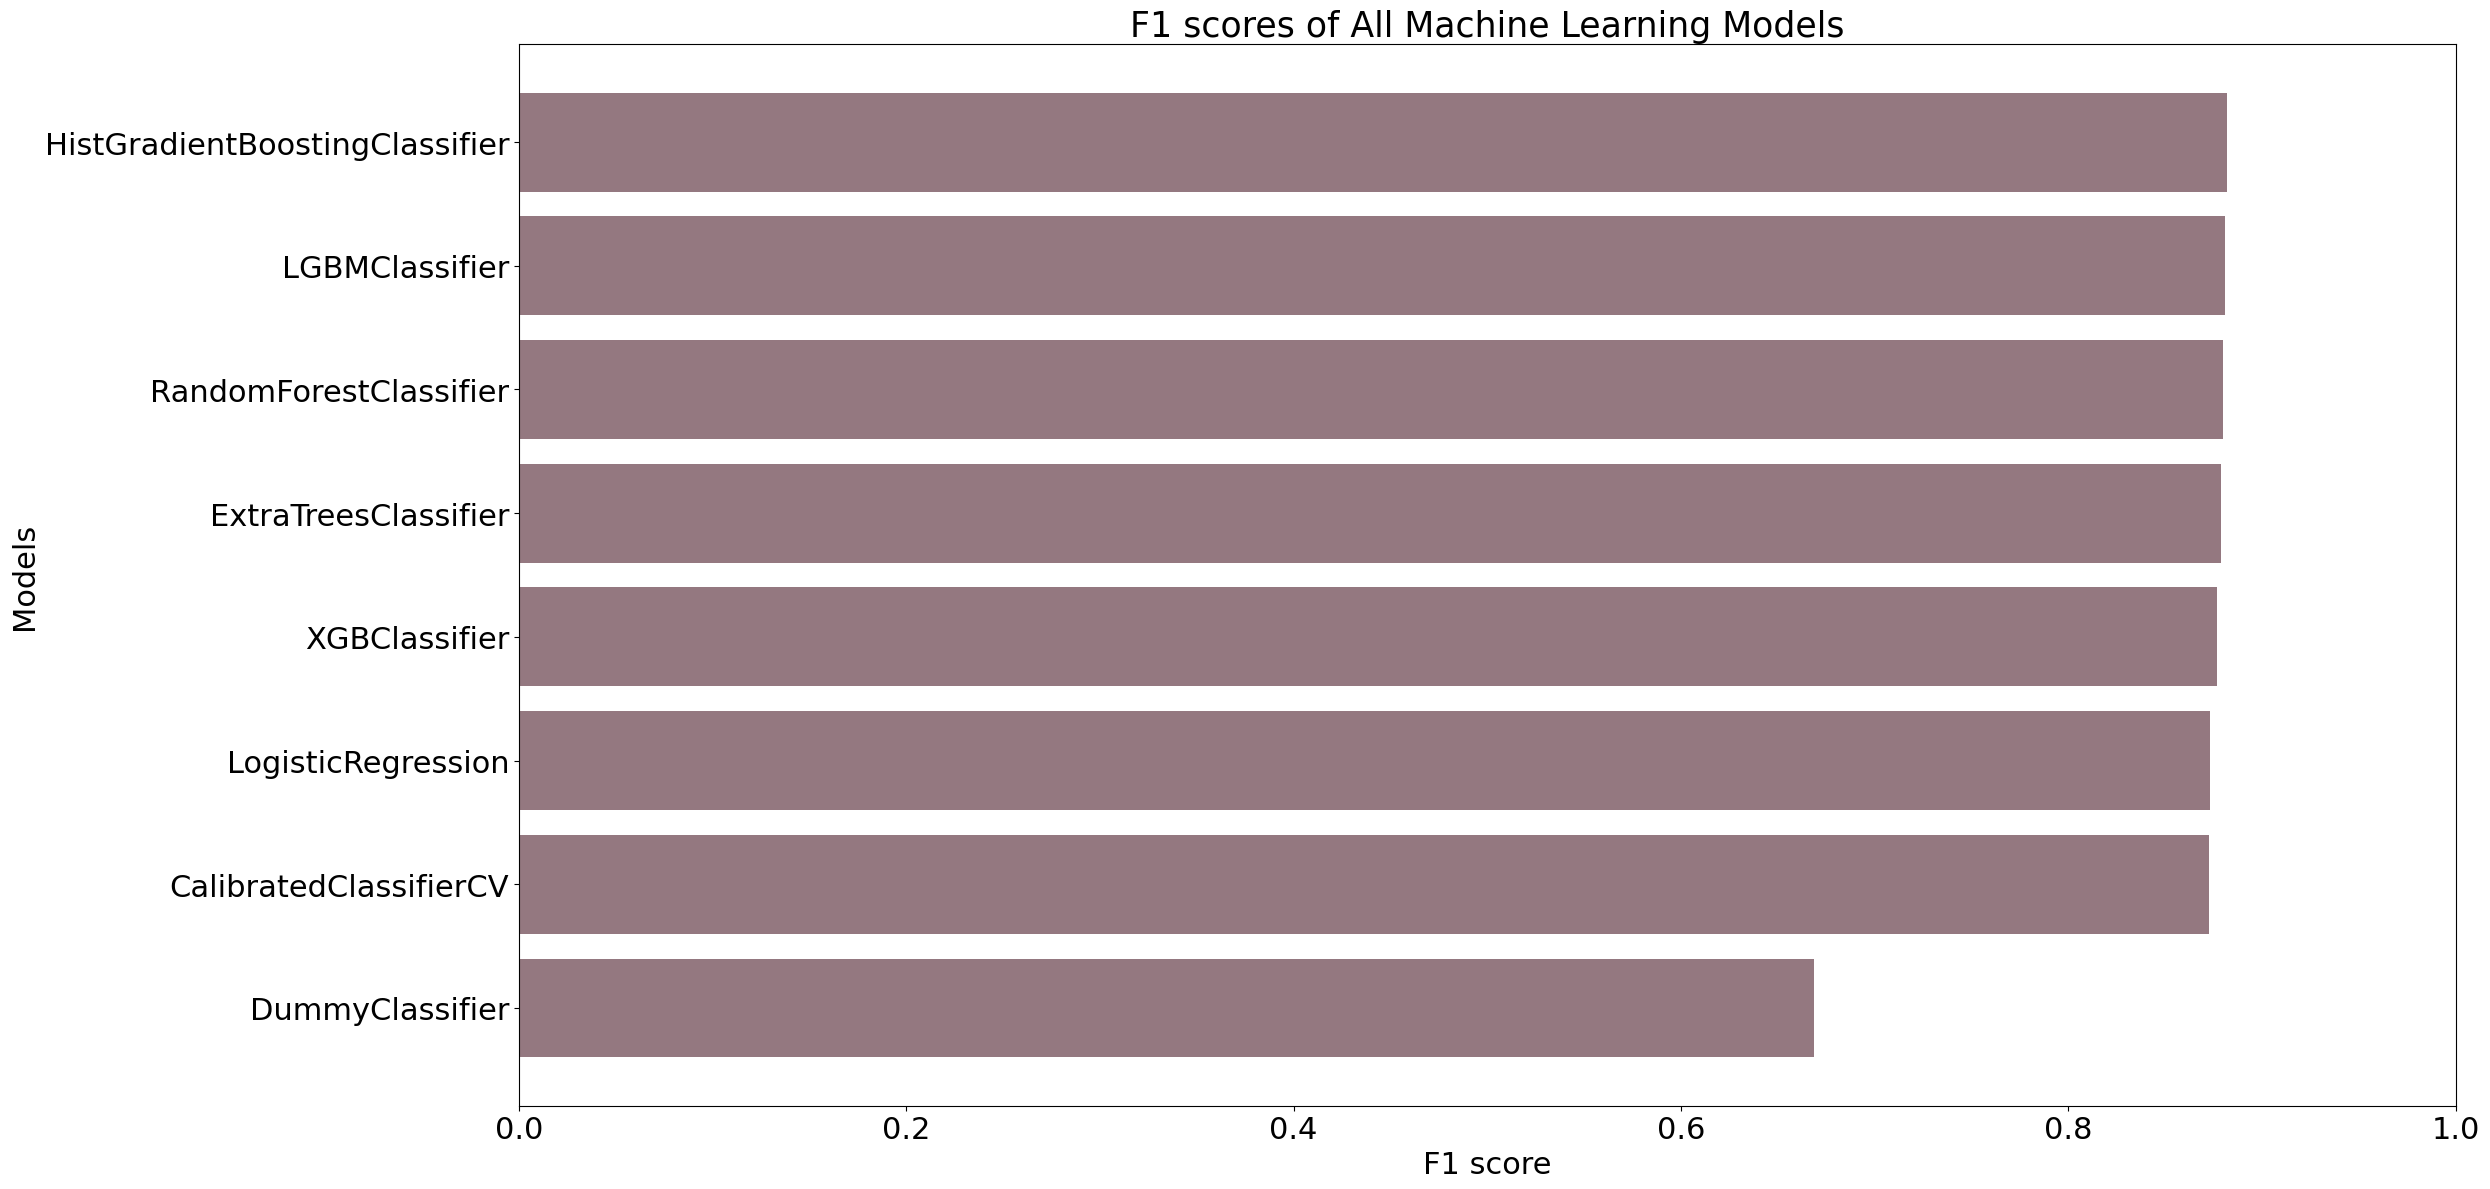

In [ ]:
plt.figure(figsize=(25, 12))
plt.barh(top7["model"], top7["accuracy"], color=bar_col)
plt.xlabel("Accuracy", fontsize=22)
plt.ylabel("Models", fontsize=22)
plt.title("Accuracy of All Machine Learning Models", fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0, 1.0)
plt.gca().invert_yaxis()

plt.savefig("all model accuracy")
plt.tight_layout()
plt.show()

plt.figure(figsize=(25, 12))
plt.barh(top7["model"], top7["F1 score"], color=f1_bar_col)
plt.xlabel("F1 score", fontsize=22)
plt.ylabel("Models", fontsize=22)
plt.title("F1 scores of All Machine Learning Models", fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0, 1.0)
plt.gca().invert_yaxis()
plt.savefig("all model f1 score")
plt.tight_layout()
plt.show()

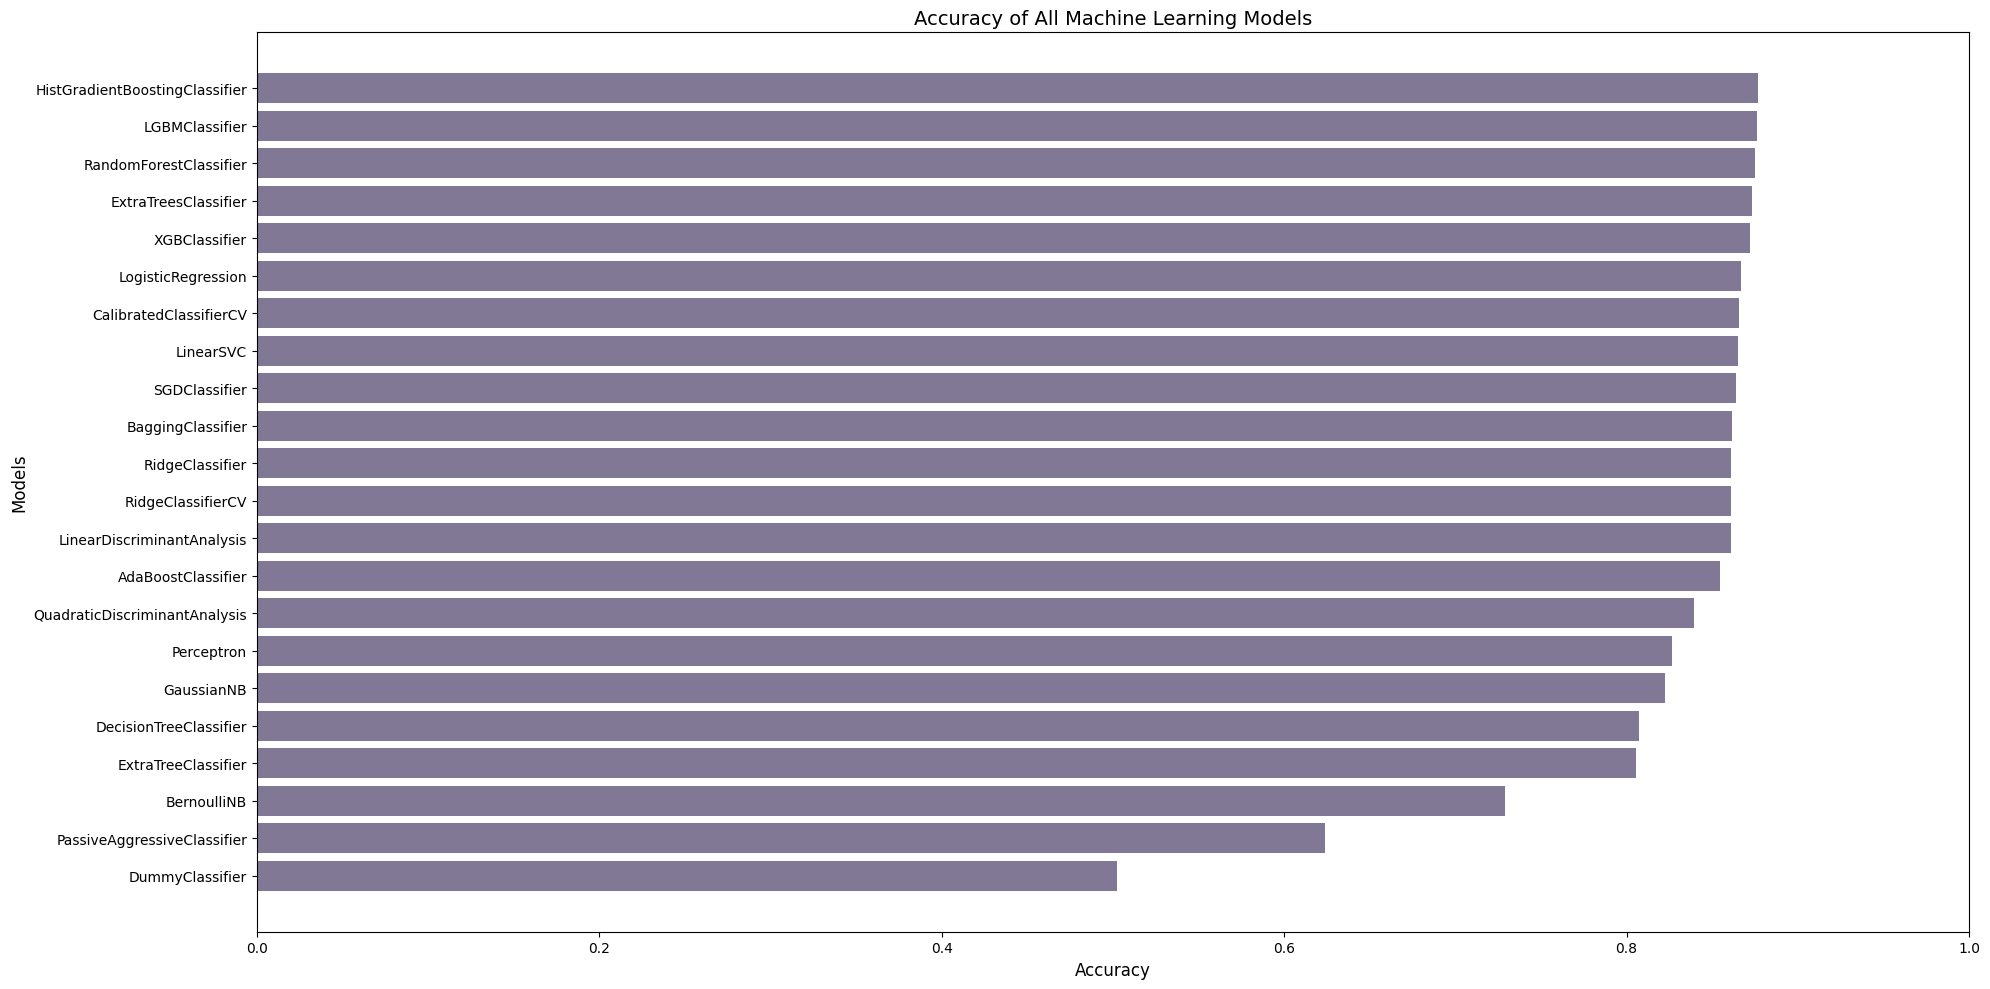

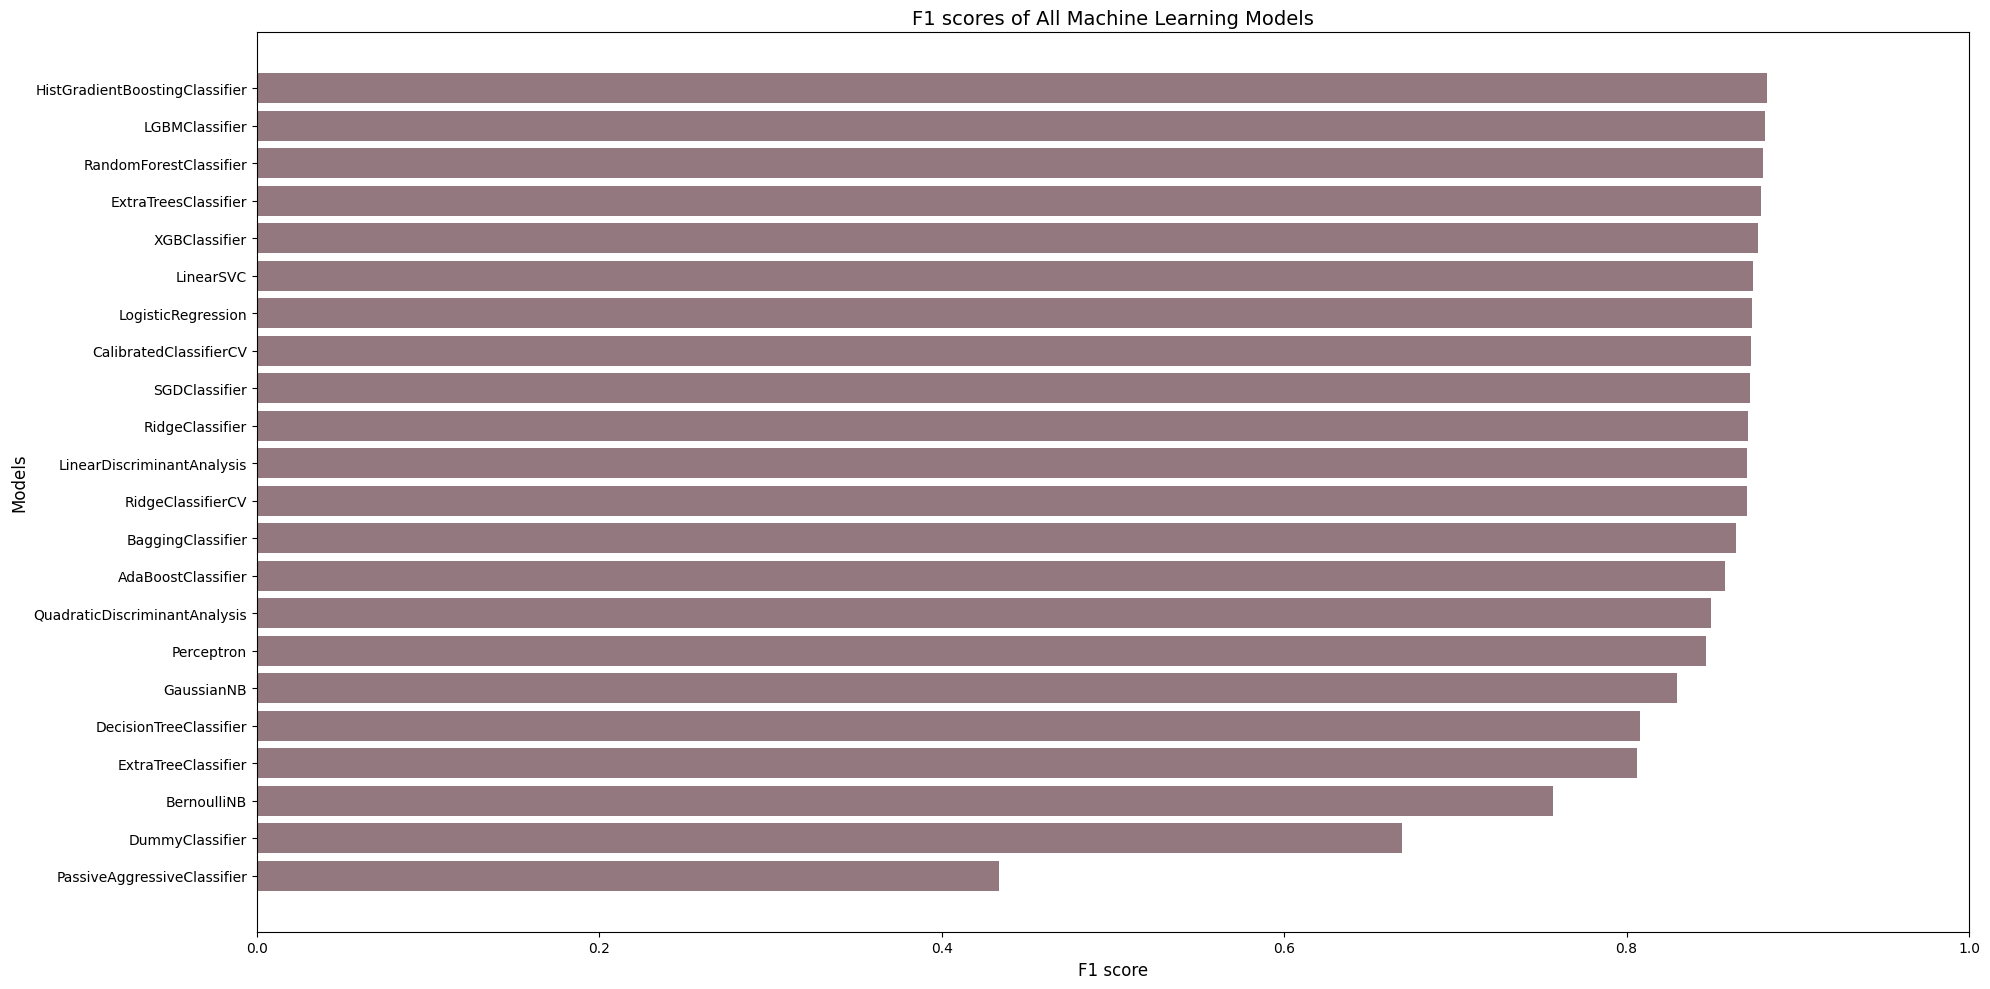

c:\Users\shwet\Desktop\Somatic_Var\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


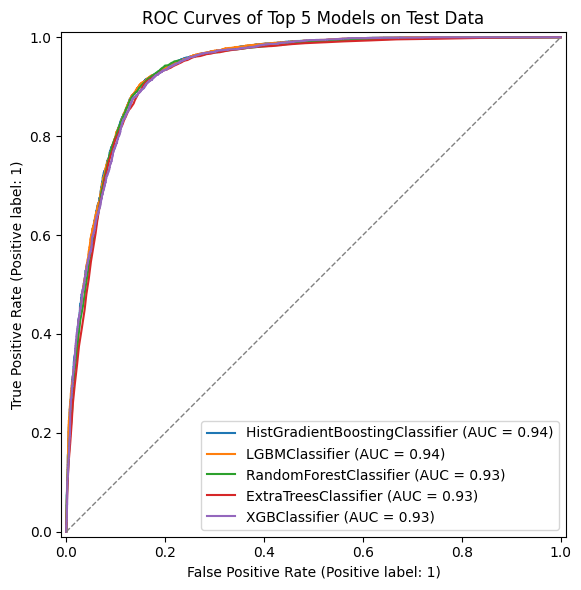

c:\Users\shwet\Desktop\Somatic_Var\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


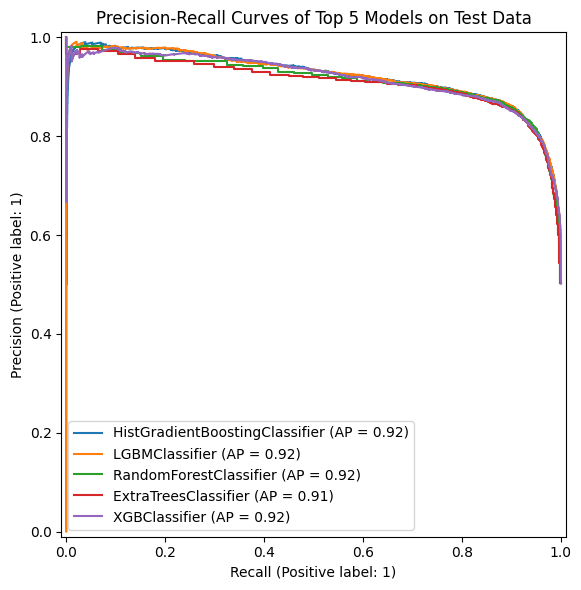

In [ ]:
top_names = top5["model"].tolist()

plt.figure(figsize=(20, 10))
plt.barh(sort_test_df["model"], sort_test_df["accuracy"], color=bar_col)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.title("Accuracy of All Machine Learning Models", fontsize=14)
plt.xlim(0, 1.0)
plt.gca().invert_yaxis()
plt.savefig("all model accuracy")
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plt.barh(sort_f1_test["model"], sort_f1_test["F1 score"], color=f1_bar_col)
plt.xlabel("F1 score", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.title("F1 scores of All Machine Learning Models", fontsize=14)
plt.xlim(0, 1.0)
plt.gca().invert_yaxis()
plt.savefig("all model f1 score")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 6))
for name in top_names:
    y_score = proba(top_mod[name], X_test)
    RocCurveDisplay.from_predictions(y_test, y_score, name=name, ax=ax)
ax.plot([0, 1], [0, 1], "--", linewidth=1, color="gray")
ax.set_title("ROC Curves of Top 5 Models on Test Data")
plt.savefig("ROC curves")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 6))
for name in top_names:
    y_score = proba(top_mod[name], X_test)
    PrecisionRecallDisplay.from_predictions(y_test, y_score, name=name, ax=ax)    
ax.set_title("Precision-Recall Curves of Top 5 Models on Test Data")
plt.savefig("P-R curves")
fig.tight_layout()
plt.show()

In [36]:
test_df

,model,accuracy,F1 score,precision,recall,roc_auc,area_under_prec_recall,confusion_matrix
0,HistGradientBoostingClassifier,0.876950,0.881973,0.851310,0.914926,0.936892,0.923237,"[[4333, 834], [444, 4775]]"
1,LGBMClassifier,0.875891,0.880836,0.851018,0.912819,0.936700,0.922971,"[[4333, 834], [455, 4764]]"
2,RandomForestClassifier,0.875120,0.879785,0.852065,0.909370,0.932910,0.915600,"[[4343, 824], [473, 4746]]"
3,ExtraTreesClassifier,0.873291,0.878732,0.846441,0.913585,0.929293,0.910259,"[[4302, 865], [451, 4768]]"
4,XGBClassifier,0.872136,0.876923,0.849219,0.906495,0.933853,0.918341,"[[4327, 840], [488, 4731]]"


In [37]:
top5

,model,accuracy,F1 score,precision,recall,roc_auc,area_under_prec_recall,confusion_matrix
0,HistGradientBoostingClassifier,0.876950,0.881973,0.851310,0.914926,0.936892,0.923237,"[[4333, 834], [444, 4775]]"
1,LGBMClassifier,0.875891,0.880836,0.851018,0.912819,0.936700,0.922971,"[[4333, 834], [455, 4764]]"
2,RandomForestClassifier,0.875120,0.879785,0.852065,0.909370,0.932910,0.915600,"[[4343, 824], [473, 4746]]"
3,ExtraTreesClassifier,0.873291,0.878732,0.846441,0.913585,0.929293,0.910259,"[[4302, 865], [451, 4768]]"
4,XGBClassifier,0.872136,0.876923,0.849219,0.906495,0.933853,0.918341,"[[4327, 840], [488, 4731]]"


In [38]:
down_df.columns

Index(['label', 'GC', 'DP', 'NDP', 'HOMO', 'STRAND_BIAS', 'QUAL', 'DELTA_AF',
       'REF_A', 'REF_C', 'REF_G', 'REF_T', 'ALT_A', 'ALT_C', 'ALT_G', 'ALT_T'],
      dtype='object')

In [34]:
feature_names = down_df.drop("label", axis=1).columns.tolist()
X_train_val_df = pd.DataFrame(X_train_val, columns=feature_names)
X_test_df      = pd.DataFrame(X_test,      columns=feature_names)

In [33]:
base_est = top_mod["HistGradientBoostingClassifier"] 

In [ ]:
def subset_feature_importance(
    base_estimator,
    X_train, y_train,
    X_test, y_test,
    feature_names,
    n_runs=2000,
    subset_size=3,
    random_state=42):
    rng = np.random.RandomState(random_state)
    
    acc_per_feature = {f: [] for f in feature_names}
    
    n_features = len(feature_names)
    feature_indices = np.arange(n_features)
    
    for i in range(n_runs):
      
        chosen_idx = rng.choice(feature_indices, size=subset_size, replace=False)
        chosen_feats= [feature_names[j] for j in chosen_idx]
        Xtr_sub = X_train[chosen_feats]
        Xte_sub= X_test[chosen_feats]
        est = clone(base_estimator)
        est.fit(Xtr_sub, y_train)
        y_pred = est.predict(Xte_sub)
        acc= accuracy_score(y_test, y_pred)
        for f in chosen_feats:
            acc_per_feature[f].append(acc)
    

    rows = []
    for f in feature_names:
        vals = acc_per_feature[f]
        if len(vals) == 0:
            mean_acc = np.nan
            count = 0
        else:
            mean_acc = float(np.mean(vals))
            count = len(vals)
        rows.append({"feature": f, "mean_accuracy": mean_acc, "n_models": count})
    
    df_imp = (pd.DataFrame(rows).sort_values("mean_accuracy", ascending=False).reset_index(drop=True))
    
    return df_imp

In [ ]:
fi_hist = subset_feature_importance(base_estimator=base_est,X_train=X_train_val_df,y_train=y_train_val,
    X_test=X_test_df,y_test=y_test,
    feature_names=feature_names,n_runs=500,subset_size=3)

fi_hist

,feature,mean_accuracy,n_models
0,QUAL,0.854332,103
1,DELTA_AF,0.825447,90
2,NDP,0.674688,98
3,STRAND_BIAS,0.671112,94
4,DP,0.666644,109
5,REF_G,0.653629,100
6,REF_T,0.653024,109
7,ALT_T,0.651835,79
8,ALT_A,0.650368,100
9,ALT_G,0.649486,101


In [38]:
feat_bar_col = (0.17, # redness
         0.30, # greenness
         0.12, # blueness
         0.6 )# transparency (from https://python-graph-gallery.com/3-control-color-of-barplots/)

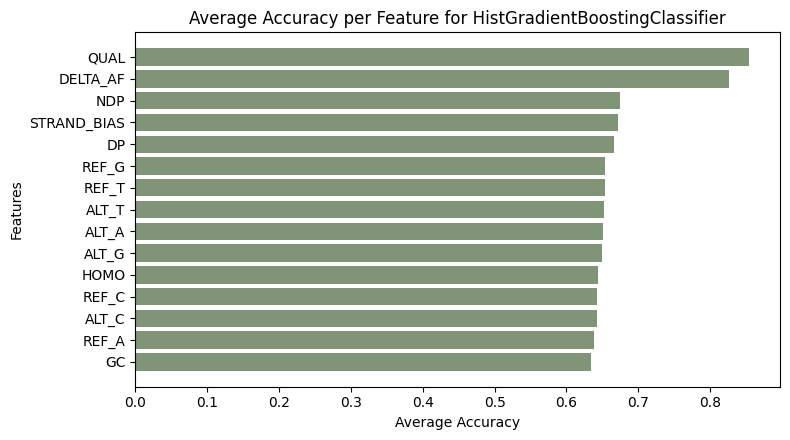

In [41]:
plt.figure(figsize=(8, max(4, len(fi_hist) * 0.3)))
plt.barh(fi_hist["feature"][::-1], fi_hist.iloc[:, 1][::-1], color=feat_bar_col)
plt.xlabel("Average Accuracy")
plt.ylabel("Features")
plt.title(f"Average Accuracy per Feature for HistGradientBoostingClassifier")
plt.tight_layout()
plt.savefig("feat imp")
plt.show()